In [1]:
import os
import re
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from simulation_utils.calibration import Calibrator, compute_cosine_similarity_pd, _sample_pairs
from simulation_utils.datasets import DataStats, az_music_instruments
from simulation_utils.preference import LatentDirichletAllocationCSR, IndianBuffetProcessCSR, generate_ibp_itemwise, generate_lda, generate_lda_nbp
from simulation_utils.observation import PopularityObservationCSR, UniformObservationCSR
from simulation_utils.observation import sample_uniform_n, sample_popular_n, TruncParetoProfile
from simulation_utils.utils import TruncatedPareto
from simulation_utils.utils import truncated_beta_binomial, truncated_pareto
# %matplotlib inline

In [3]:
def ibp_unif_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_unif.pkl', savetofile=True):
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [4]:
def ibp_pop_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [5]:
def lda_pop_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                   m=20.00000045, alpha=0.510528, upper=737, 
                   fname='lda_pop.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [6]:
def lda_unif_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                    m=20.00000045, alpha=0.510528, upper=737, 
                    fname='lda_unif.pkl', savetofile=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [7]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [8]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [9]:
def summarize_dataset(name, data_func, *args, **kwargs):
    if isinstance(data_func, pd.DataFrame):
        dataset = data_func
    else:
        dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
#     user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
#     item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [10]:
def make_grids(figsize=(14, 6), ngrids_left=3, ngrids_right=1):
    fig = plt.figure(figsize=figsize)
    gs_left = GridSpec(ngrids_left, 1)
    gs_left.update(left=0.05, right=0.48, wspace=0.05, hspace=0.05)
    for i in range(ngrids_left):
        ax = plt.subplot(gs_left[i, 0])
    for ax in fig.axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[1:]:
        ax.spines['top'].set_visible(False)

    gs_right = GridSpec(ngrids_right, 1)
    gs_right.update(left=0.55, right=0.98, wspace=0.05, hspace=0.05)
    for i in range(ngrids_right):
        ax = plt.subplot(gs_right[i, 0])
    for ax in fig.axes[ngrids_left:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[ngrids_left+1:]:
        ax.spines['top'].set_visible(False)
    return fig, fig.axes

In [19]:
def plot_stats(base, simulated, base_arg=(), args=(), ylim_left=None, ylim_left2=None, ylim_left4=None, mrated=1):
    """
    Args:
        base (`tuple` of str, function): name and data function
        simulated (`tuple` of `str`, `function`): name and data function
        args: position args for simulated data function
    """
    ml_name, data_func, lda_name, simulated_lda_func = *base, *simulated
    data = data_func(*base_arg)
    data['rating'] = 1
    if callable(simulated_lda_func):
        simulated_lda = simulated_lda_func(*args)
    else:
        simulated_lda = simulated_lda_func
    simulated_lda['rating'] = 1
    ml_meta, ml_uastats, ml_ipstats, ml_ua, ml_ip = summarize_dataset(ml_name, data)
    lda_meta, lda_uastats, lda_ipstats, lda_ua, lda_ip = summarize_dataset(lda_name, simulated_lda)
    # show data stats
    df = pd.DataFrame.from_records([ml_meta, lda_meta],
                                   columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    df = pd.concat([ml_ipstats, lda_ipstats], axis=1)
    print('item popularity stats')
    print(df)
    df = pd.concat([ml_uastats, lda_uastats], axis=1)
    print('user profile stats')
    print(df)
    # minimum n ratings
    ml_upairs = ml_ua[ml_ua['count'] >= mrated]['user'].values
    ml_ipairs = ml_ip[ml_ip['count'] >= mrated]['item'].values
    lda_upairs = lda_ua[lda_ua['count'] >= mrated]['user'].values
    lda_ipairs = lda_ip[lda_ip['count'] >= mrated]['item'].values
    data_ucosine = data[data['user'].isin(ml_upairs)]
    data_icosine = data[data['item'].isin(ml_ipairs)]
    simulated_lda_ucosine = simulated_lda[simulated_lda['user'].isin(lda_upairs)]
    simulated_lda_icosine = simulated_lda[simulated_lda['item'].isin(lda_ipairs)]

    ml_dcorr = compute_cosine_similarity_pd(data_icosine, _sample_pairs, 'item', 'user')
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_icosine, _sample_pairs, 'item', 'user')
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    # plot distributions
    if ylim_left is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['corr'], ax=ax, label=key, axlabel=False)
            if ylim_left is not None:
                axes[i].set_ylim(*ylim_left[i])
    axes[0].legend()
    ax = sns.boxplot(x='dataset', y='corr', hue='dataset', data=data2plot, ax=axes[-1])
    ax.legend(loc='upper right')
    fig.suptitle('item item similarity')
    plt.show()
    
    # second plot
    ml_dcorr = compute_cosine_similarity_pd(data_ucosine, _sample_pairs)
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_ucosine, _sample_pairs)
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    if ylim_left2 is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left2))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['corr'], ax=ax, label=key, axlabel=False)
            if ylim_left2 is not None:
                axes[i].set_ylim(*ylim_left2[i])
    axes[0].legend()
    ax = sns.boxplot(x='dataset', y='corr', hue='dataset', data=data2plot, ax=axes[-1])
    ax.legend(loc='upper right')
    fig.suptitle('user user similarity')
    plt.show()
    # third plot
    data2plot = pd.concat([ml_ip, lda_ip], ignore_index=True) 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sns.scatterplot('rank', 'count', hue='dataset', ax=ax1, data=data2plot)
    ax1.set(xscale="log", yscale="log")
    ax1.set_title('item popularity curve')
    data2plot = data2plot.groupby(['dataset', 'count']).size().reset_index().rename(columns={'count': 'popularity', 0: 'count'})
    sns.scatterplot('popularity', 'count', hue='dataset', ax=ax2, data=data2plot)
    ax2.set(xscale="log", yscale="log")
    ax2.set_title('popularity distribution')
    plt.show()
    # fourth plot
    data2plot = pd.concat([ml_ua, lda_ua], ignore_index=True)
    if ylim_left4 is not None:
        fig, axes = make_grids(ngrids_left=len(ylim_left4))
    else:
        fig, axes = make_grids(ngrids_left=1)
    for i, ax in enumerate(axes[:-1]):
        for key, group in data2plot.groupby('dataset'):
            axes[i] = sns.distplot(group['count'], ax=ax, label=key, axlabel=False, hist_kws={'alpha':0.5}, kde=False)
            if ylim_left4 is not None:
                axes[i].set_ylim(*ylim_left4[i])
    axes[0].legend()
    axes[0].set_title('activity distribution')
    data2plot = data2plot.groupby(['dataset', 'count']).size().reset_index().rename(columns={'count': 'activity', 0: 'count'})
    ax = sns.scatterplot('activity', 'count', hue='dataset', ax=axes[-1], data=data2plot)
    ax.set_title('activity distribution')
    plt.show()

## Amazon music instruments

### lda unif on user user

[109, 38.651307753816475, 0.4392645838849039, 0.265084181032981, 1.0743007731040801, 1.2544605199487748, 505.4813463828638] 0.008572041247342089
simulated data is used


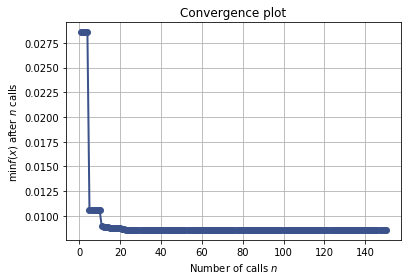

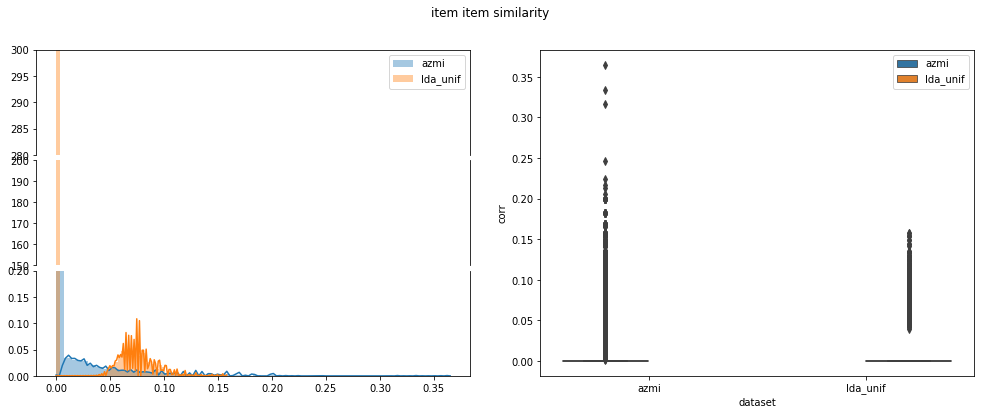

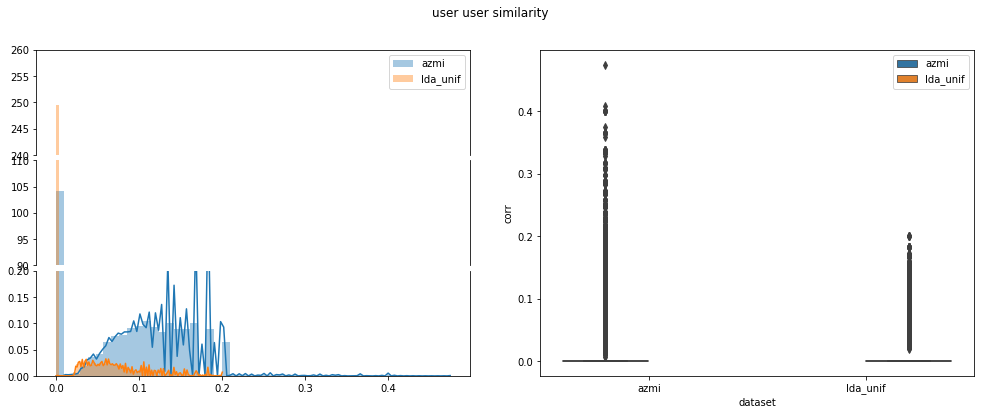

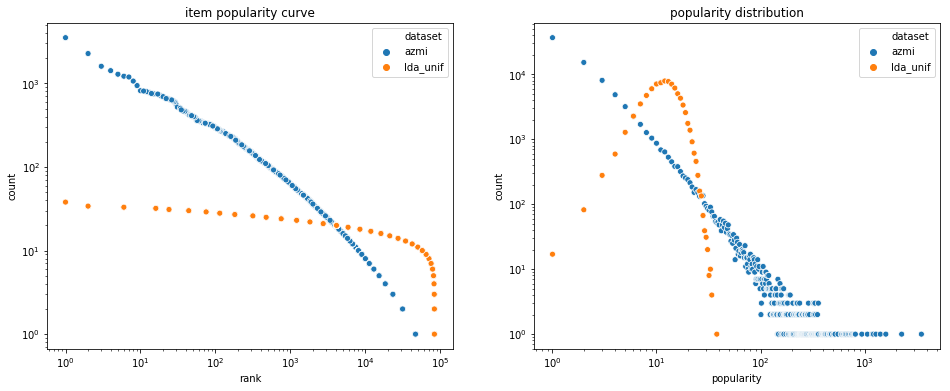

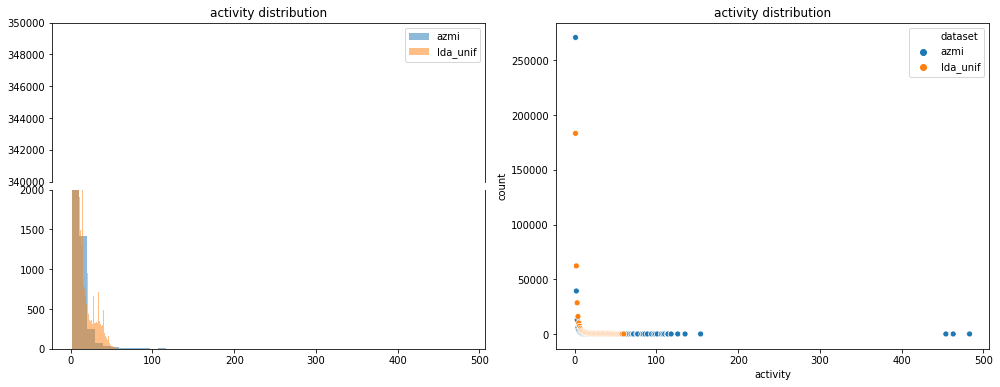

dataset stats
    dataset  nusers  nitems   npairs   density
0      azmi  339231   83046   500176  0.000018
1  lda_unif  339231   83041  1068437  0.000038
item popularity stats
               azmi      lda_unif
count  83046.000000  83041.000000
mean       6.022879     12.866379
std       28.294073      4.318455
min        1.000000      1.000000
25%        1.000000     10.000000
50%        2.000000     13.000000
75%        4.000000     16.000000
max     3523.000000     38.000000
user profile stats
                azmi       lda_unif
count  339231.000000  339231.000000
mean        1.474441       3.149585
std         2.342608       5.439146
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       3.000000
max       483.000000      60.000000


In [17]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_instruments-ucorr-1-2019-04-07-22-50-08.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azmi_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', lda_unif_pareto), args=[339231, 83046, *res_gp.x, 'lda_unif_azmi_ucorr.pkl'], 
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', simulated_data), 
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda unif on item item

[10, 499.99999999999994, 0.5634137261166032, 0.01, 1.2, 3.2263591062133954, 579.5999999999998] 0.0002646350832131792
file not found, simulating data on the fly


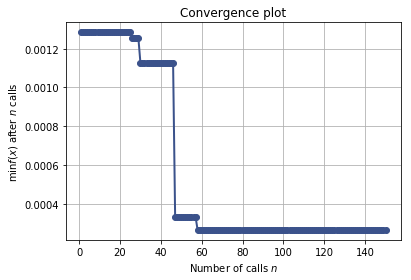

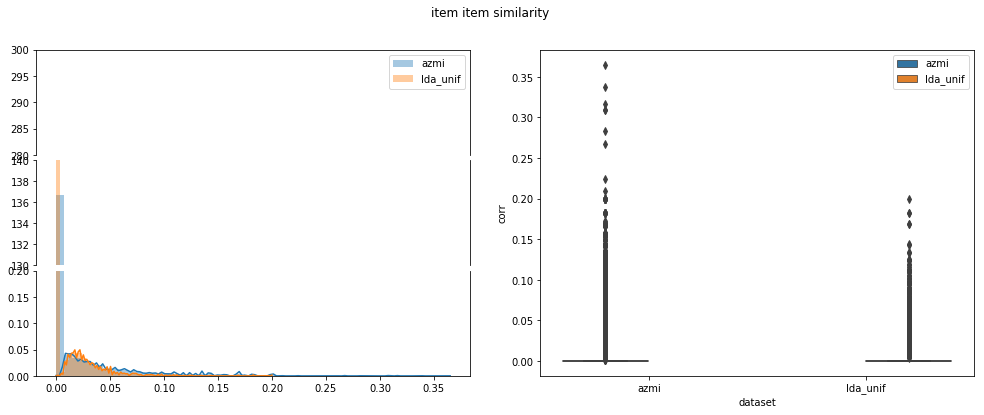

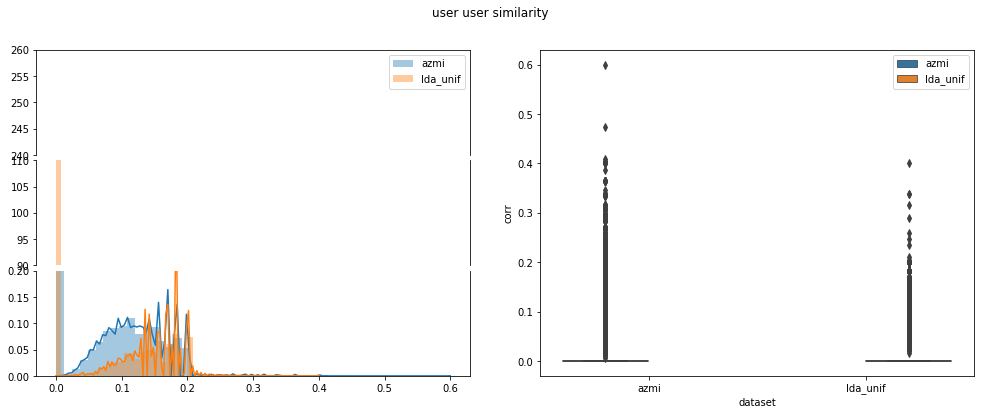

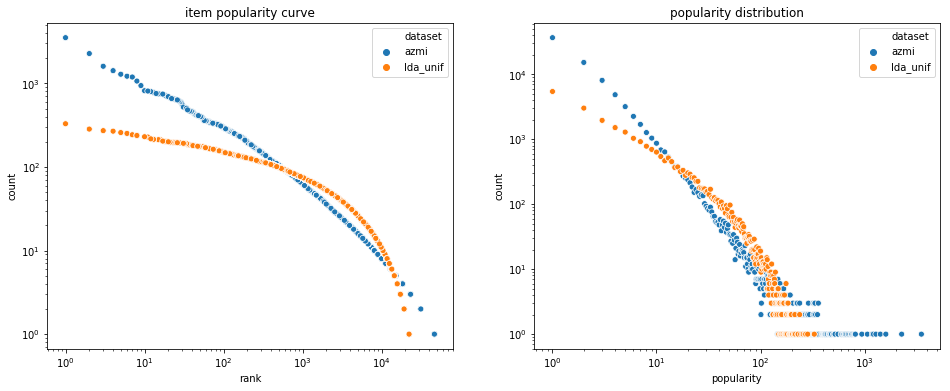

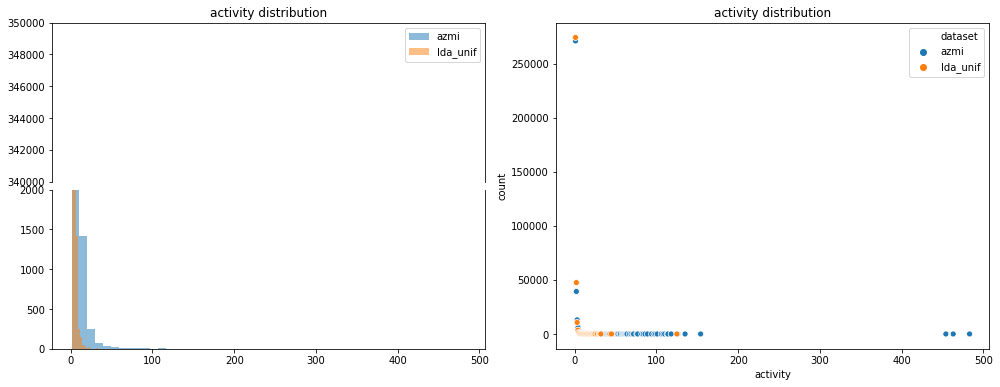

dataset stats
    dataset  nusers  nitems  npairs   density
0      azmi  339231   83046  500176  0.000018
1  lda_unif  339231   27655  438557  0.000047
item popularity stats
               azmi      lda_unif
count  83046.000000  27655.000000
mean       6.022879     15.858145
std       28.294073     24.364938
min        1.000000      1.000000
25%        1.000000      2.000000
50%        2.000000      6.000000
75%        4.000000     19.000000
max     3523.000000    329.000000
user profile stats
                azmi       lda_unif
count  339231.000000  339231.000000
mean        1.474441       1.292798
std         2.342608       0.868193
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       483.000000     125.000000


In [18]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_instruments-icorr-1-2019-04-07-22-50-28.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azmi_icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', lda_unif_pareto), args=[339231, 83046, *res_gp.x, 'lda_unif_azmi_icorr.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda unif on item pop

[52, 210.68903631667936, 1.0, 0.01601381839198815, 24.0, 0.5086181809991873, 2776.7999999999997] 0.18816563065134295
simulated data is used


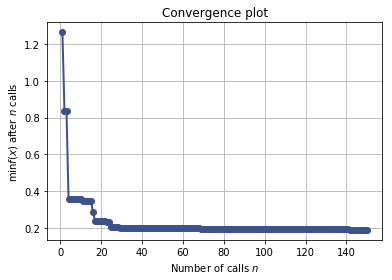

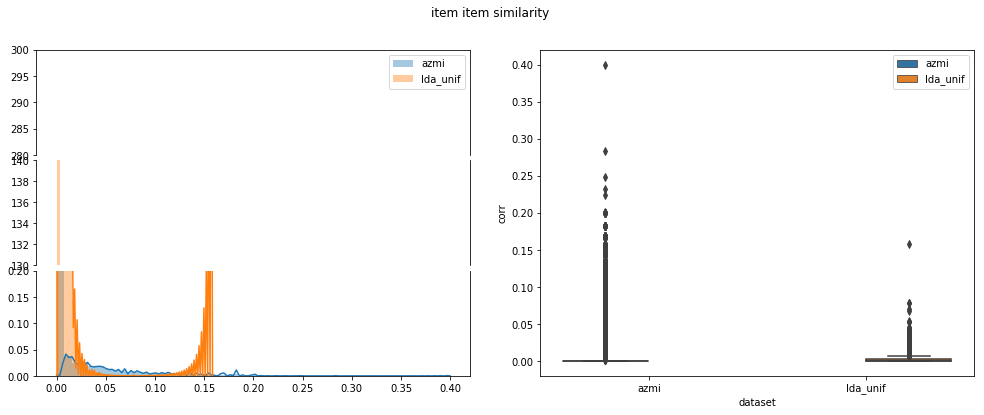

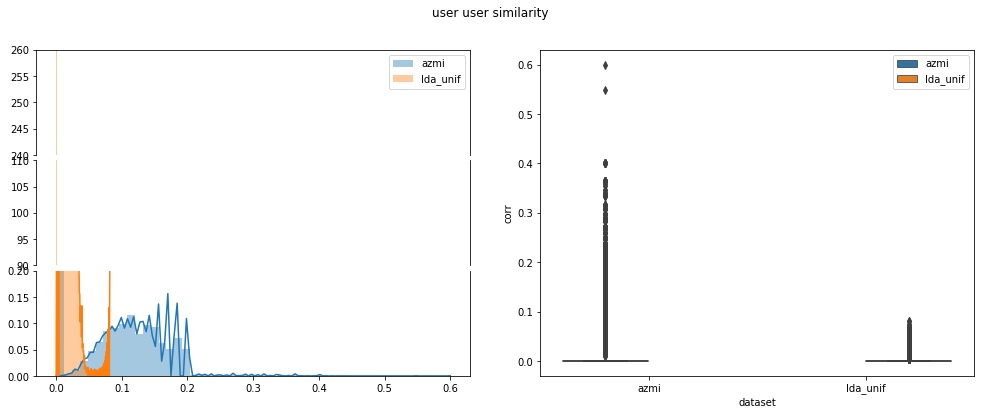

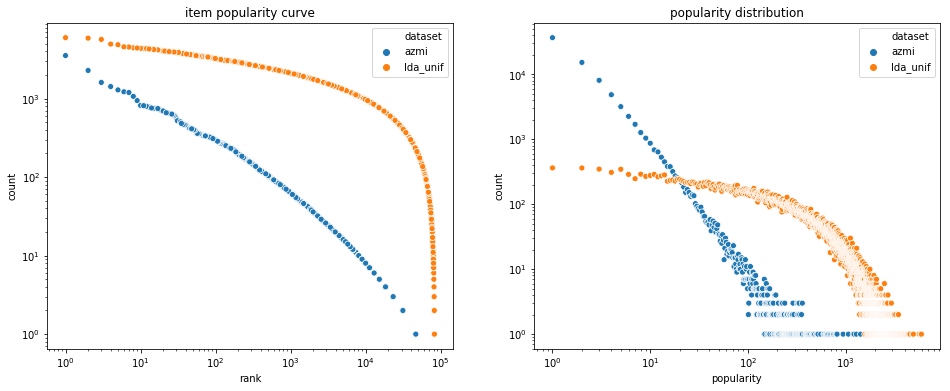

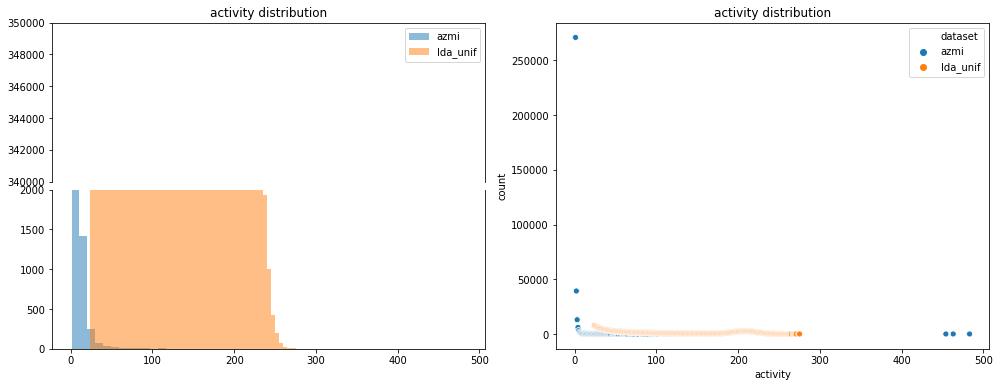

dataset stats
    dataset  nusers  nitems    npairs   density
0      azmi  339231   83046    500176  0.000018
1  lda_unif  339231   82589  36338041  0.001297
item popularity stats
               azmi      lda_unif
count  83046.000000  82589.000000
mean       6.022879    439.986451
std       28.294073    477.993489
min        1.000000      1.000000
25%        1.000000    105.000000
50%        2.000000    281.000000
75%        4.000000    610.000000
max     3523.000000   5951.000000
user profile stats
                azmi       lda_unif
count  339231.000000  339231.000000
mean        1.474441     107.118869
std         2.342608      73.551063
min         1.000000      24.000000
25%         1.000000      39.000000
50%         1.000000      79.000000
75%         1.000000     192.000000
max       483.000000     275.000000


In [15]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azmi_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', lda_unif_pareto), args=[339231, 83046, *res_gp.x, 'lda_unif_azmi_ip.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda unif on user activity

[61, 499.99999999999994, 0.01, 0.2242572198444323, 1.0, 2.2696783599716226, 386.40000000000015] 0.0008981612693418397
simulated data is used


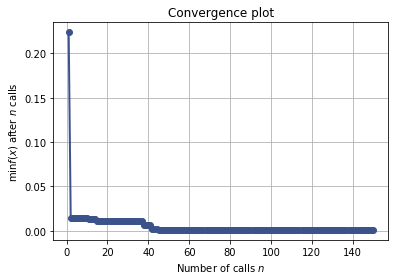

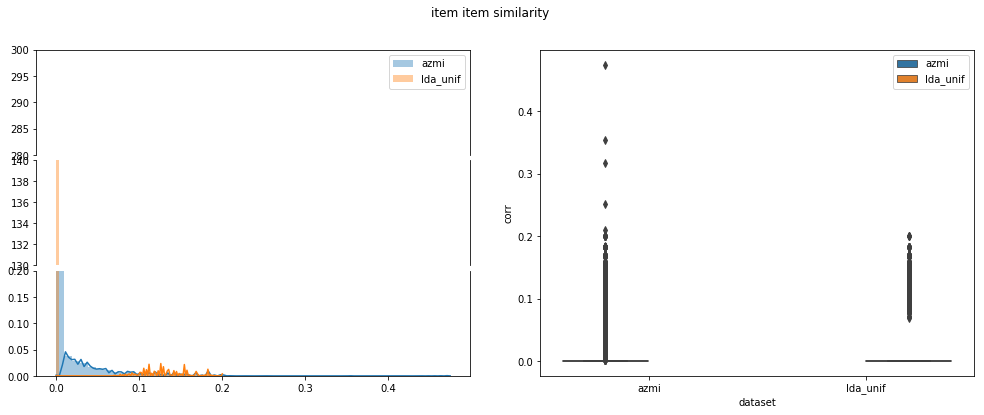

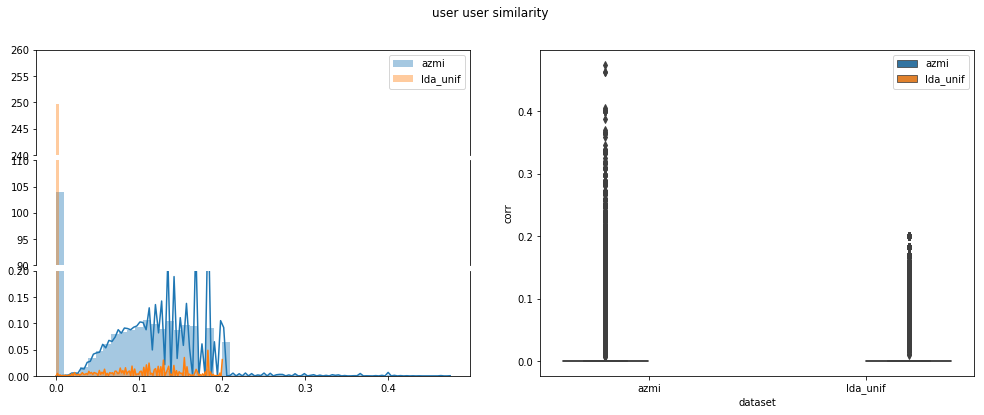

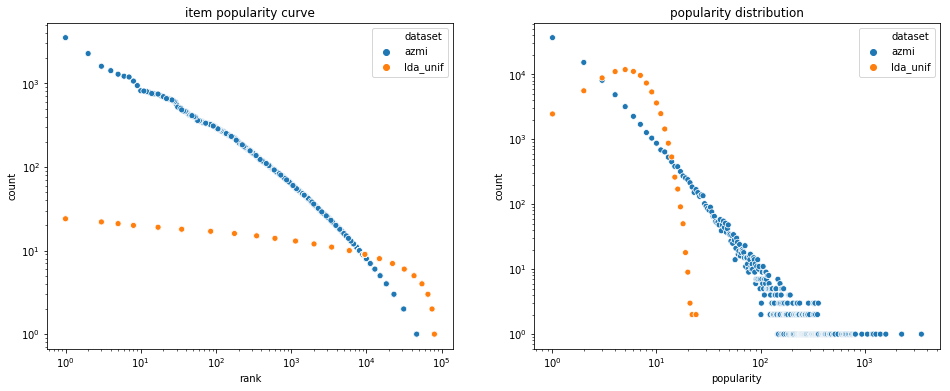

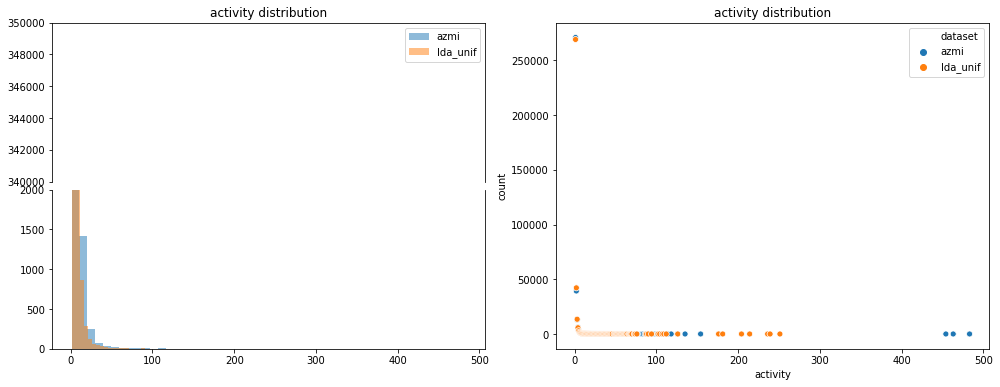

dataset stats
    dataset  nusers  nitems  npairs   density
0      azmi  339231   83046  500176  0.000018
1  lda_unif  339231   82463  492362  0.000018
item popularity stats
               azmi      lda_unif
count  83046.000000  82463.000000
mean       6.022879      5.970702
std       28.294073      2.878421
min        1.000000      1.000000
25%        1.000000      4.000000
50%        2.000000      6.000000
75%        4.000000      8.000000
max     3523.000000     24.000000
user profile stats
                azmi       lda_unif
count  339231.000000  339231.000000
mean        1.474441       1.451406
std         2.342608       2.000652
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       483.000000     251.000000


In [16]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_instruments-user-act-1-2019-04-07-23-55-18.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azmi_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', lda_unif_pareto), args=[339231, 83046, *res_gp.x, 'lda_unif_azmi_ua.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.2)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda unif on all

[183, 5.754762647940413, 0.40716456210900365, 0.04684191188092415, 1.0168972524168376, 3.857999340694086, 414.92578921183383] 0.8763692342845048
simulated data is used


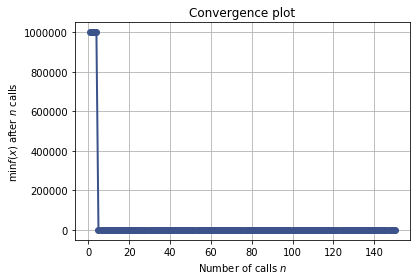

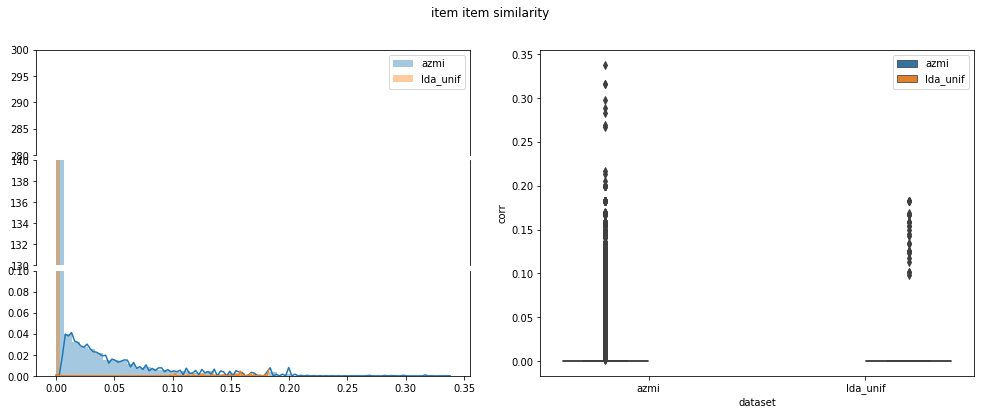

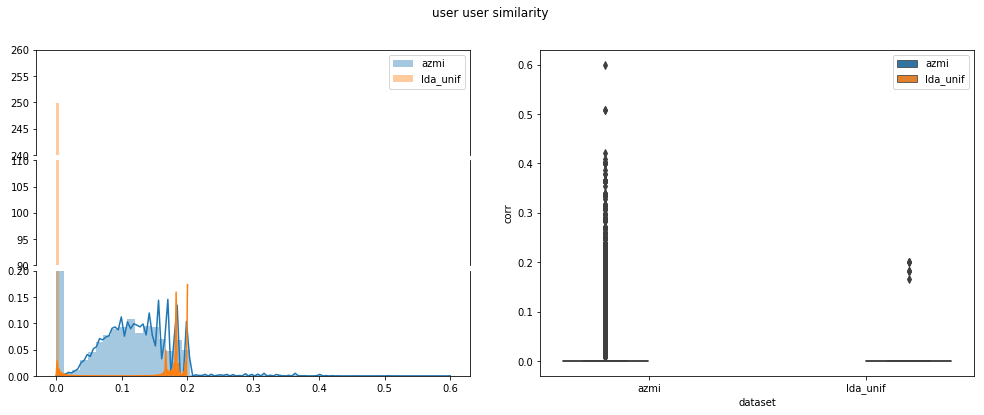

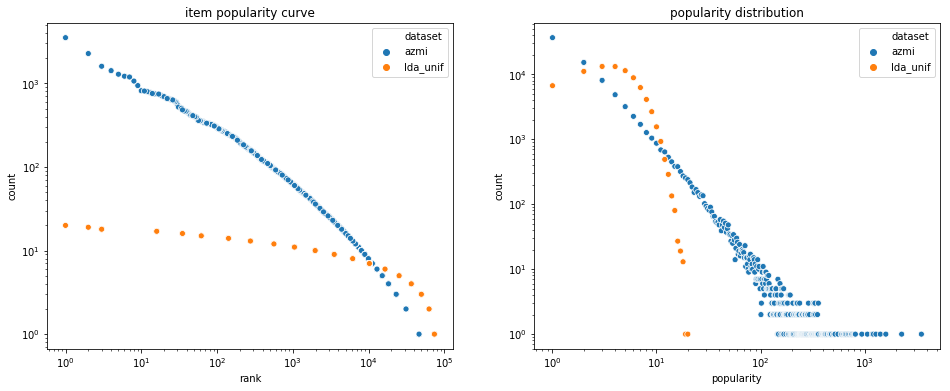

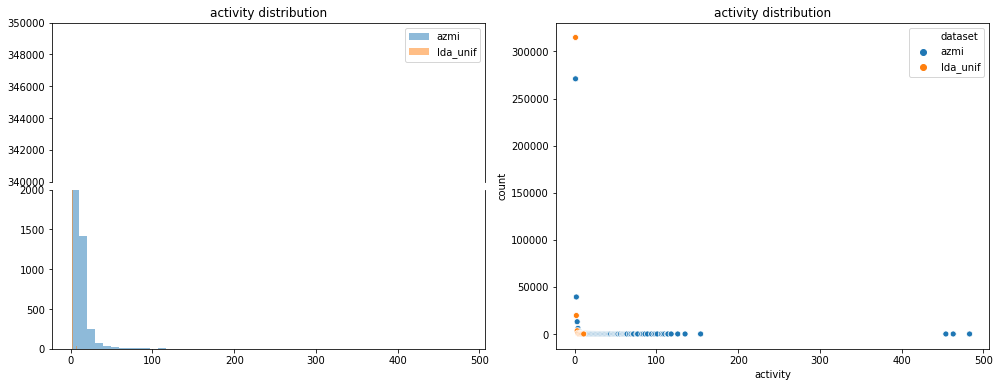

dataset stats
    dataset  nusers  nitems  npairs   density
0      azmi  339231   83046  500176  0.000018
1  lda_unif  339231   80786  370519  0.000014
item popularity stats
               azmi      lda_unif
count  83046.000000  80786.000000
mean       6.022879      4.586426
std       28.294073      2.520923
min        1.000000      1.000000
25%        1.000000      3.000000
50%        2.000000      4.000000
75%        4.000000      6.000000
max     3523.000000     20.000000
user profile stats
                azmi       lda_unif
count  339231.000000  339231.000000
mean        1.474441       1.092232
std         2.342608       0.378365
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       483.000000      11.000000


In [17]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_instruments-all-1-2019-04-07-23-52-15.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azmi_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', lda_unif_pareto), args=[339231, 83046, *res_gp.x, 'lda_unif_azmi_all.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_unif', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda pop on item item

[132, 5.225394315085022, 0.4849704498597795, 0.011517075288690889, 1.0182672348745418, 0.12031278322109838, 512.2645554983903] 0.00018272188630745093
simulated data is used


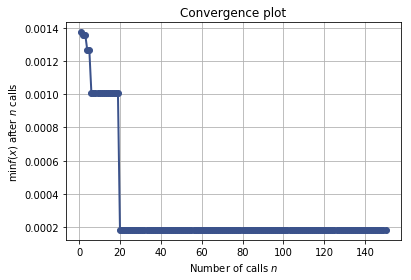

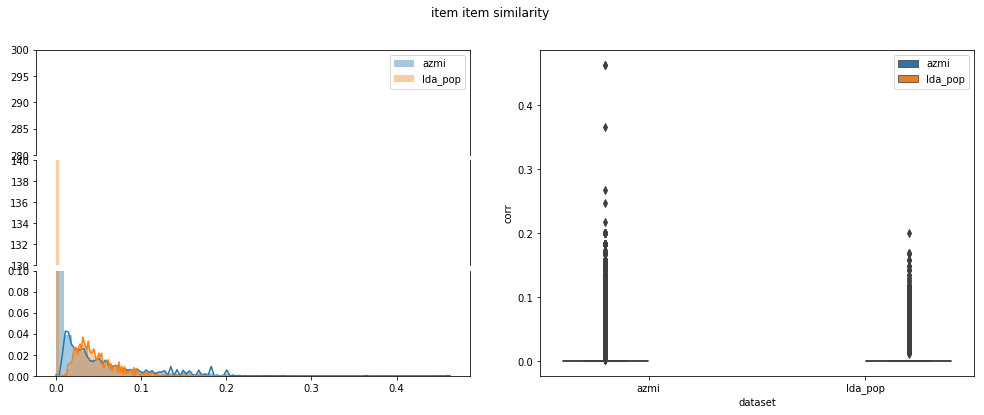

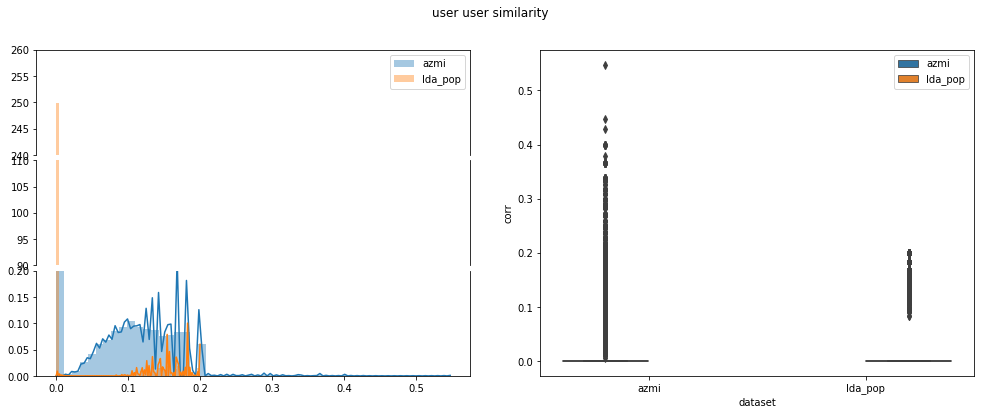

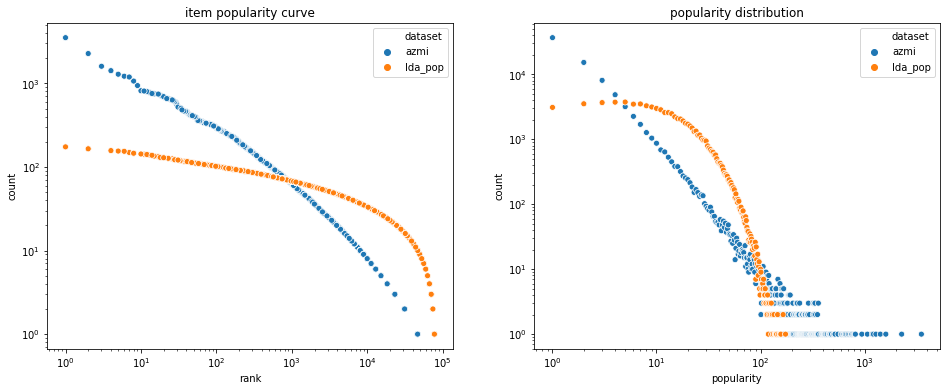

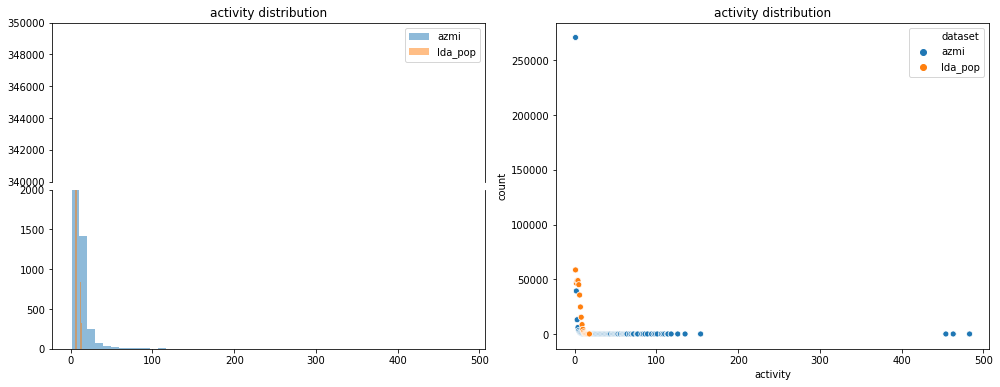

dataset stats
   dataset  nusers  nitems   npairs   density
0     azmi  339231   83046   500176  0.000018
1  lda_pop  339231   80680  1385201  0.000051
item popularity stats
               azmi       lda_pop
count  83046.000000  80680.000000
mean       6.022879     17.169075
std       28.294073     15.324913
min        1.000000      1.000000
25%        1.000000      6.000000
50%        2.000000     13.000000
75%        4.000000     23.000000
max     3523.000000    174.000000
user profile stats
                azmi        lda_pop
count  339231.000000  339231.000000
mean        1.474441       4.083356
std         2.342608       2.414865
min         1.000000       1.000000
25%         1.000000       2.000000
50%         1.000000       4.000000
75%         1.000000       6.000000
max       483.000000      18.000000


In [18]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_instruments-icorr-1-2019-04-08-01-34-51.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_azmi_icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', lda_pop_pareto), args=[339231, 83046, *res_gp.x, 'lda_pop_azmi_icorr.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda pop on user user

In [ ]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_instruments-all-1-2019-04-08-06-02-01')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_azmi_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', lda_pop_pareto), args=[339231, 83046, *res_gp.x, 'lda_pop_azmi_ucorr.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda pop on item pop

[102, 107.3236271898886, 0.1918274785430197, 0.7418522772959606, 1.0078378777045223, 12.51465249625097, 463.11974780182106] 0.7384962021614657
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     azmi  339231   83046  500176  0.000018
1  lda_pop  339231   80922  339305  0.000012
item popularity stats
               azmi       lda_pop
count  83046.000000  80922.000000
mean       6.022879      4.192988
std       28.294073      2.184514
min        1.000000      1.000000
25%        1.000000      3.000000
50%        2.000000      4.000000
75%        4.000000      6.000000
max     3523.000000     18.000000
user profile stats
                azmi        lda_pop
count  339231.000000  339231.000000
mean        1.474441       1.000218
std         2.342608       0.014768
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         1.000000       1.000000
max       483.000000       2.000000


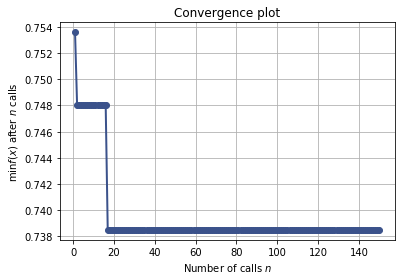

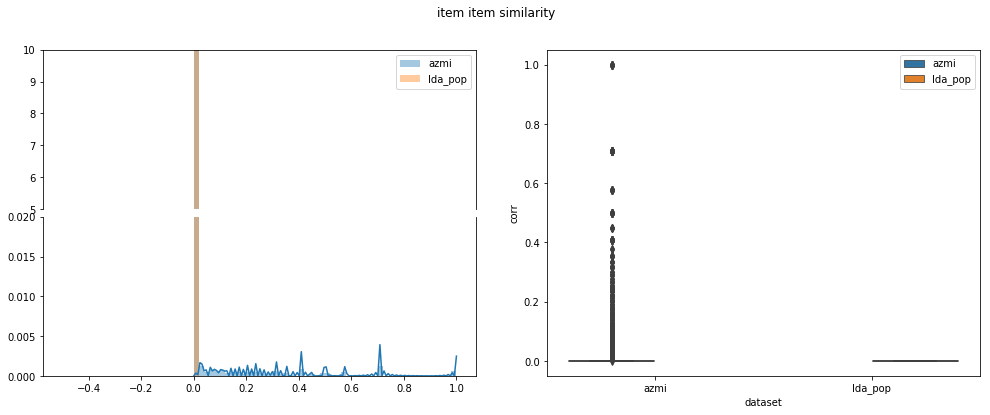

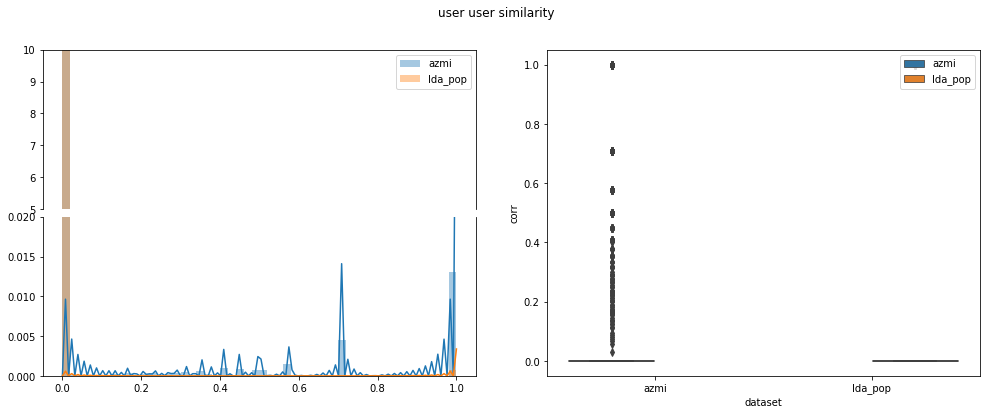

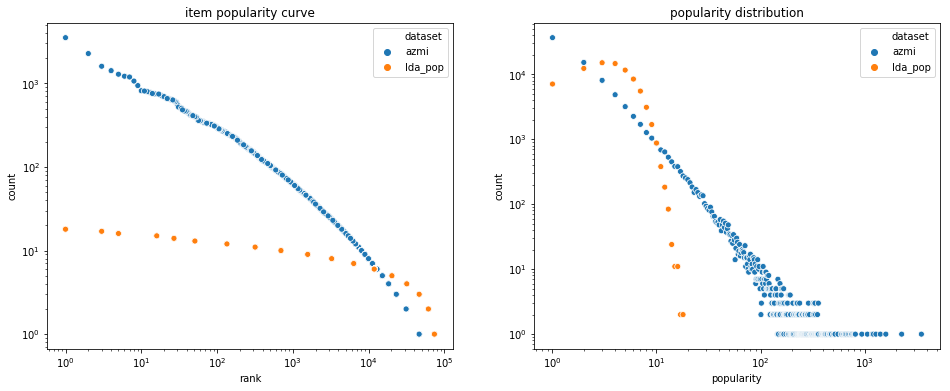

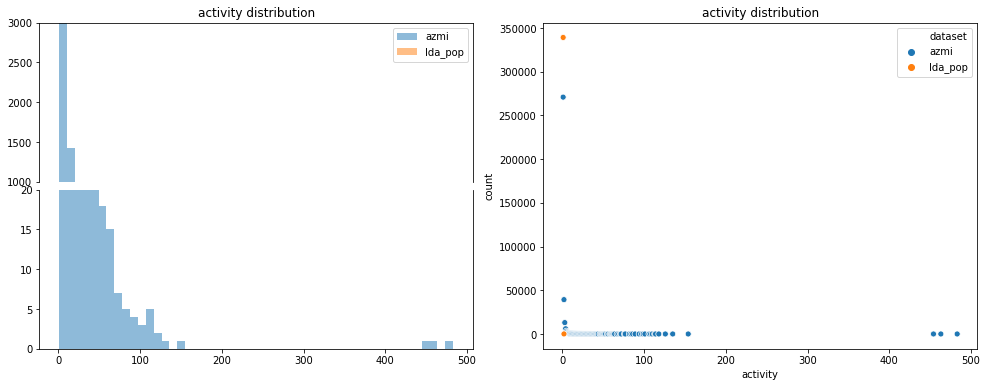

In [20]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_instruments-item-pop-1-2019-04-08-06-02-01.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_azmi_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', lda_pop_pareto), args=[339231, 83046, *res_gp.x, 'lda_pop_azmi_ip.pkl'],
               ylim_left=((5, 10), (0, 0.02)), ylim_left2=((5, 10), (0, 0.02)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', simulated_data),
               ylim_left=((5, 10), (0, 0.02)), ylim_left2=((5, 10), (0, 0.02)),
               ylim_left4=((1000, 3000), (0, 20)))

### lda pop on user activity

[100, 499.99999999999994, 0.01, 0.01, 20.715334349048984, 0.5986082611808001, 2545.4] 0.18141745198767198
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


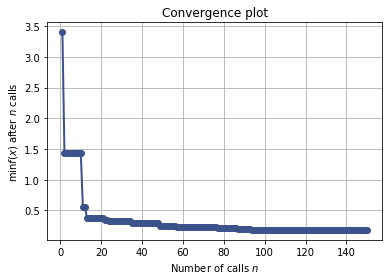

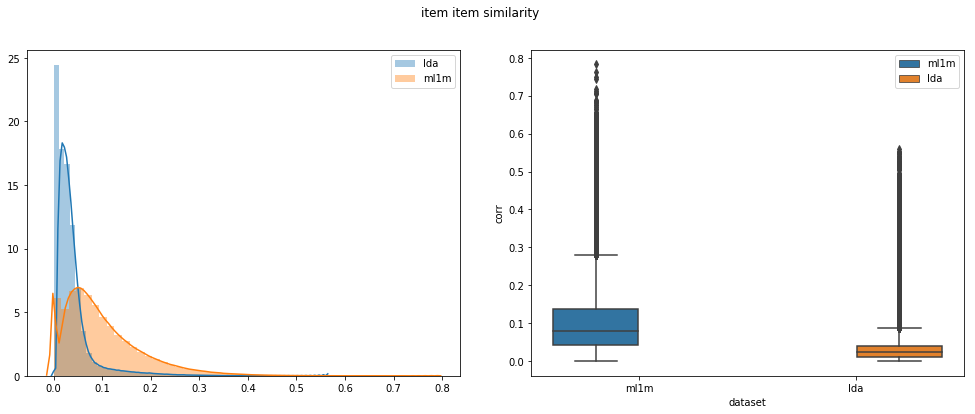

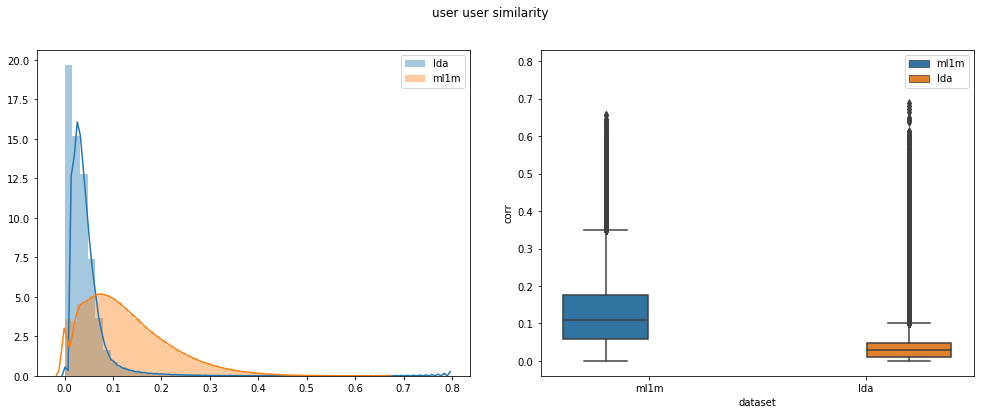

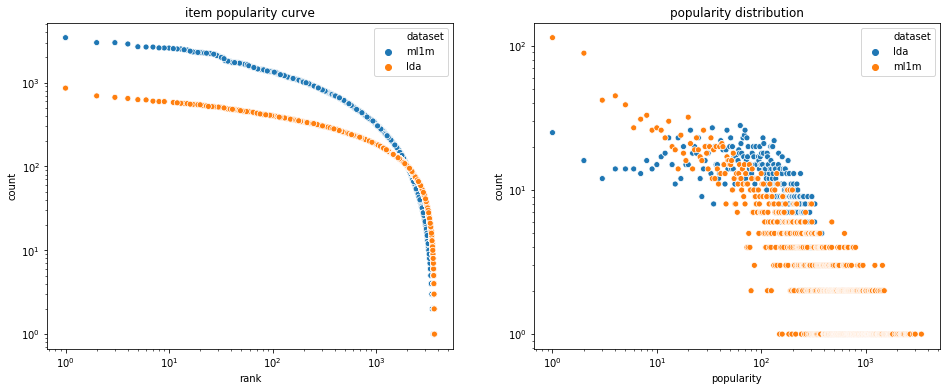

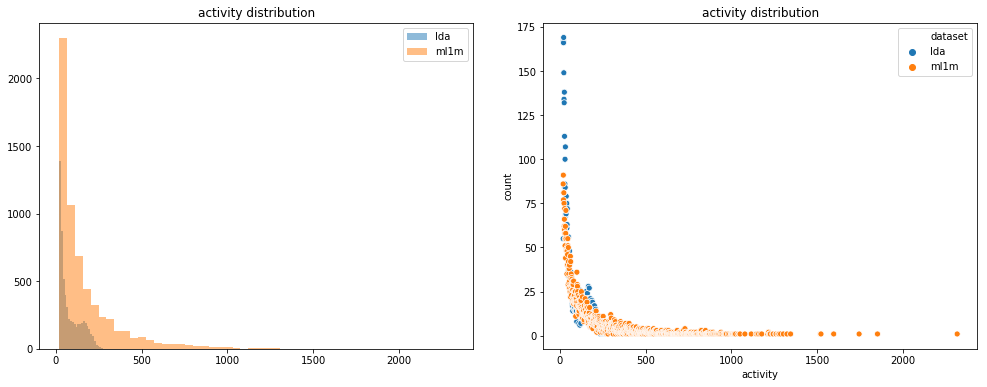

dataset stats
  dataset  nusers  nitems   npairs   density
0    ml1m    6040    3706  1000209  0.044684
1     lda    6040    3685   505798  0.022725
item popularity stats
              ml1m          lda
count  3706.000000  3685.000000
mean    269.889099   137.258616
std     384.047838   108.388067
min       1.000000     1.000000
25%      33.000000    55.000000
50%     123.500000   113.000000
75%     350.000000   194.000000
max    3428.000000   858.000000
user profile stats
              ml1m          lda
count  6040.000000  6040.000000
mean    165.597517    83.741391
std     192.747029    61.929282
min      20.000000    20.000000
25%      44.000000    32.000000
50%      96.000000    58.000000
75%     208.000000   131.000000
max    2314.000000   276.000000


In [24]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-ml_1m-user-ac.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_azmi_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', lda_pop_pareto), args=[339231, 83046, *res_gp.x, 'lda_pop_azmi_ua.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### lda pop on all

In [ ]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_instruments-all-1-2019-04-08-06-02-01.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_azmi_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', lda_pop_pareto), args=[339231, 83046, *res_gp.x, 'lda_pop_azmi_all.pkl'],
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('lda_pop', simulated_data),
               ylim_left=((280, 300), (130, 140), (0, 0.1)), ylim_left2=((240, 260), (90, 110), (0, 0.2)),
               ylim_left4=((340000, 350000), (0, 2000)))

### ibp unif on item item

[499.99999999999994, 0.7265260501287283, 0.0, 16.0, 0.1, 1851.2] 0.2413891802798733
simulated data is used


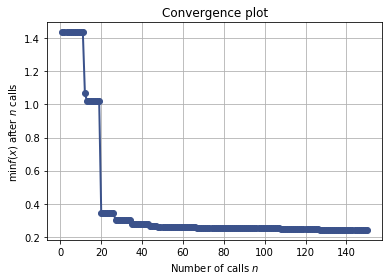

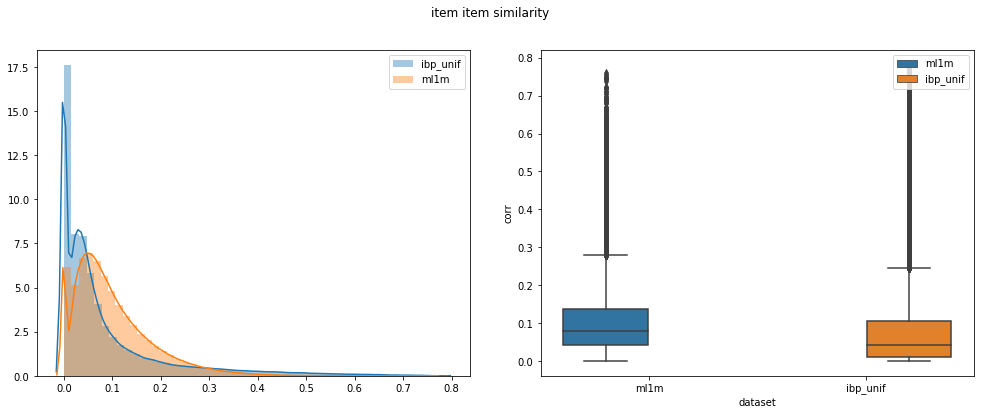

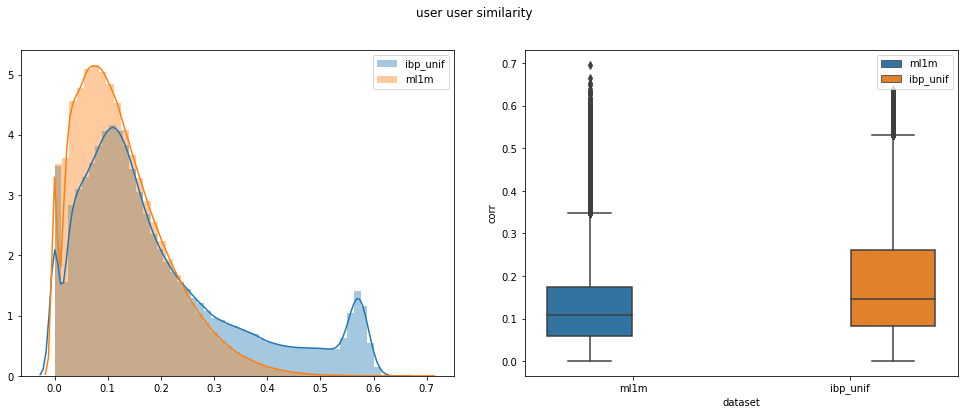

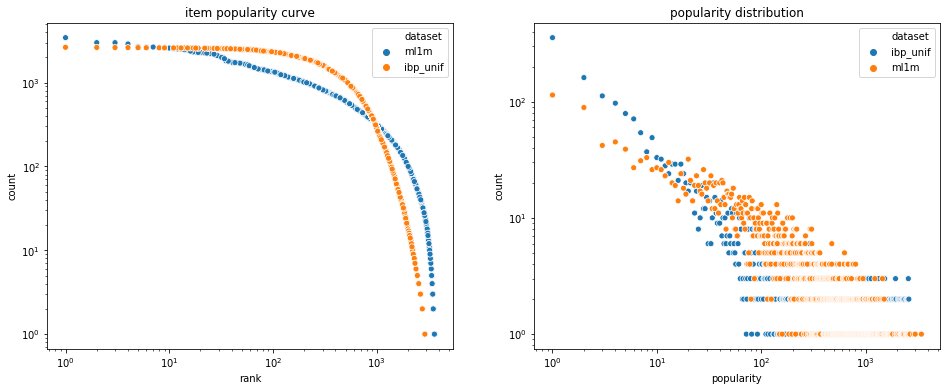

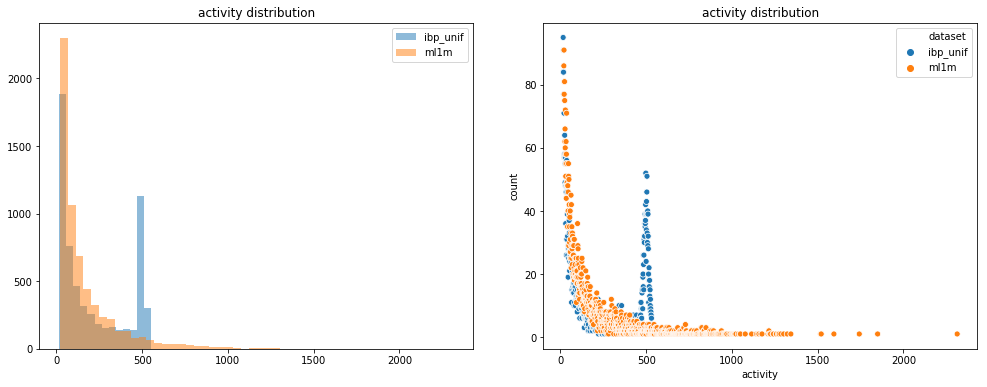

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040    3263  1305922  0.066262
item popularity stats
              ml1m     ibp_unif
count  3706.000000  3263.000000
mean    269.889099   400.221269
std     384.047838   661.513680
min       1.000000     1.000000
25%      33.000000     6.000000
50%     123.500000    50.000000
75%     350.000000   489.500000
max    3428.000000  2633.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   216.212252
std     192.747029   191.217784
min      20.000000    16.000000
25%      44.000000    44.000000
50%      96.000000   130.000000
75%     208.000000   451.000000
max    2314.000000   553.000000


In [32]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-icorr-1-2019-04-06-00-01-24.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_azmi_icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', ibp_unif_pareto), args=[339231, 83046, *res_gp.x, 'ibp_unif_azmi_icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', simulated_data))

### ibp unif on user user

[283.77264347122457, 0.01, 0.6085313565012882, 24.0, 0.6406925904029659, 2416.1620804175177] 0.03745777714348684
simulated data is used


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


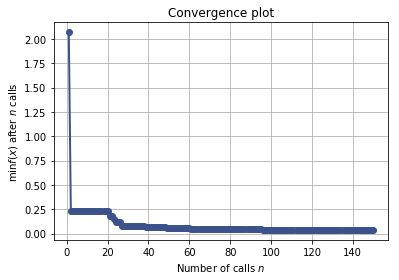

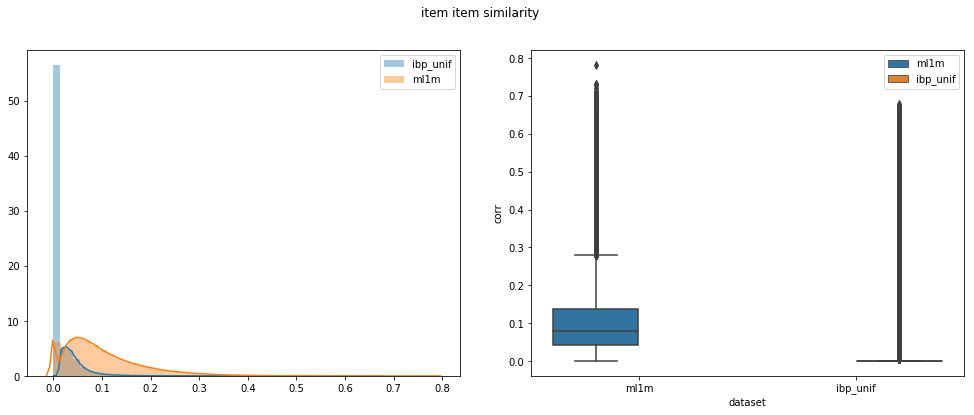

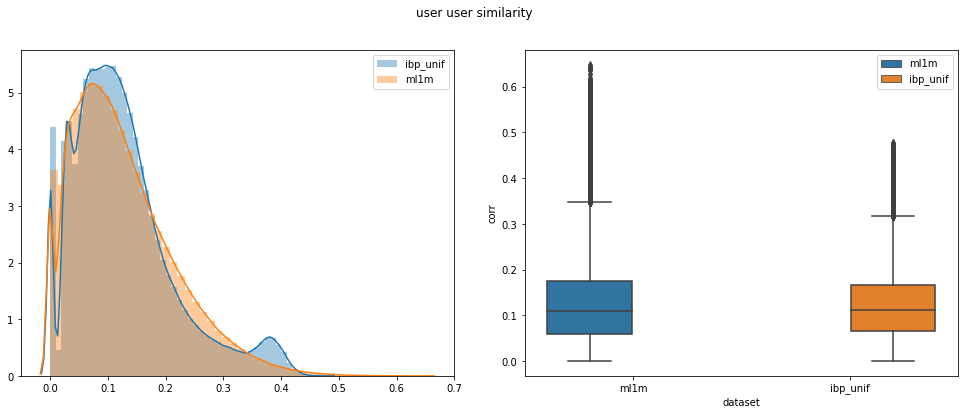

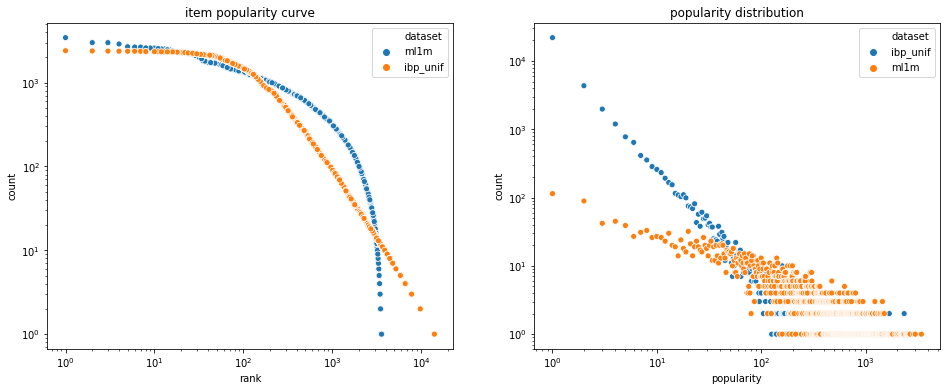

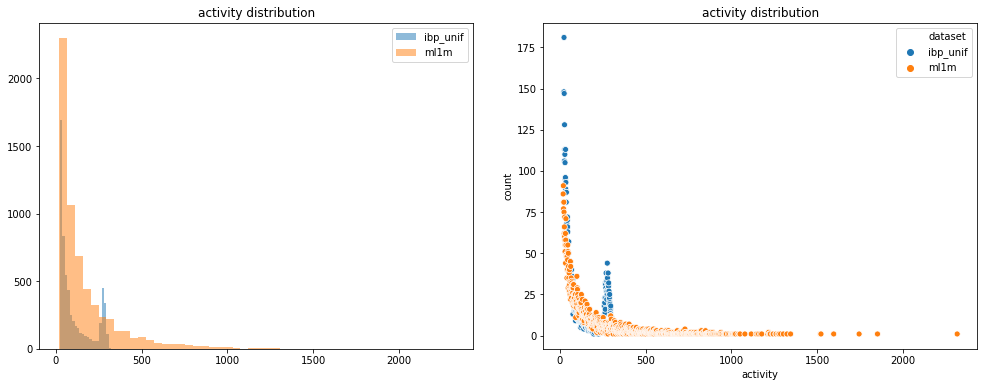

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040   36065   663234  0.003045
item popularity stats
              ml1m      ibp_unif
count  3706.000000  36065.000000
mean    269.889099     18.389963
std     384.047838    128.507311
min       1.000000      1.000000
25%      33.000000      1.000000
50%     123.500000      1.000000
75%     350.000000      3.000000
max    3428.000000   2395.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   109.806954
std     192.747029    93.225432
min      20.000000    24.000000
25%      44.000000    36.000000
50%      96.000000    65.000000
75%     208.000000   168.000000
max    2314.000000   324.000000


In [33]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_instruments-ucorr-1-2019-04-08-06-02-01.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_azmi_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', ibp_unif_pareto), args=[339231, 83046, *res_gp.x, 'ibp_unif_azmi_ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', simulated_data))

### ibp unif on item pop

[20.000000000000004, 5.7740419762167345, 0.0, 24.0, 1.1418219552440518, 1851.2] 0.1908084772090269
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


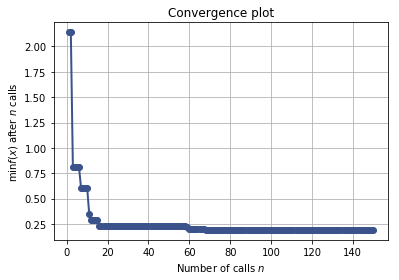

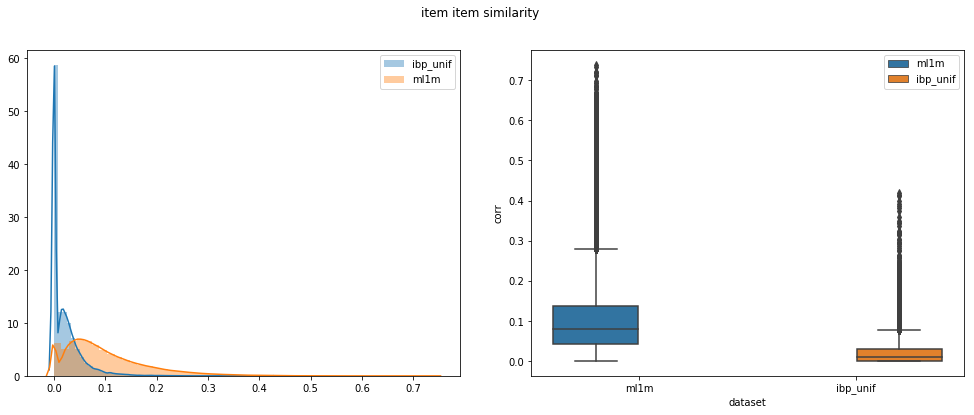

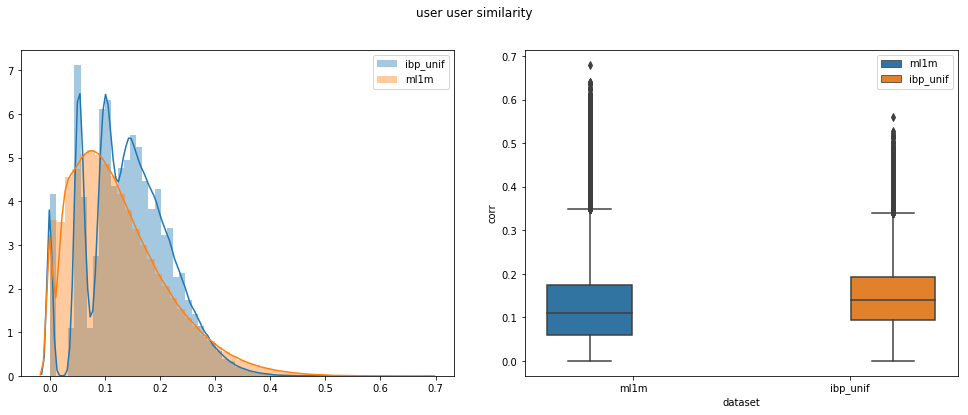

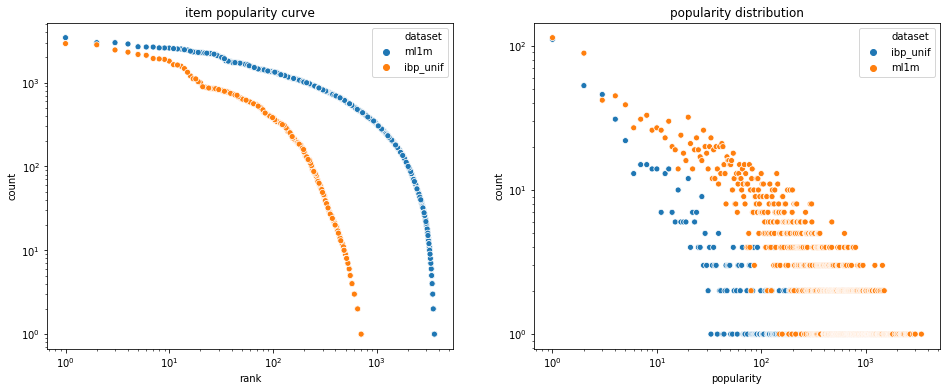

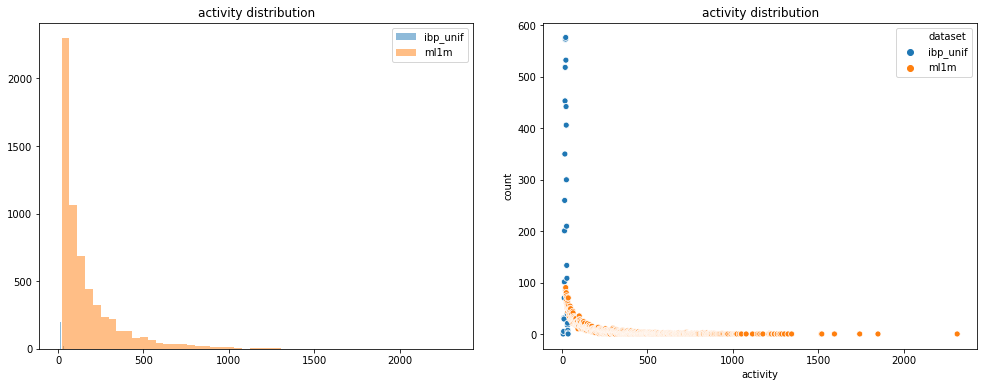

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040     817   122788  0.024883
item popularity stats
              ml1m     ibp_unif
count  3706.000000   817.000000
mean    269.889099   150.291310
std     384.047838   329.652934
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    19.000000
75%     350.000000   134.000000
max    3428.000000  2914.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517    20.329139
std     192.747029     4.078581
min      20.000000     6.000000
25%      44.000000    18.000000
50%      96.000000    20.000000
75%     208.000000    23.000000
max    2314.000000    35.000000


In [34]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_instruments-item-pop-1-2019-04-09-01-28-02.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_azmi_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', ibp_unif_pareto), args=[339231, 83046, *res_gp.x, 'ibp_unif_azmi_ip.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', simulated_data))

### ibp unif on user activity

[499.99999999999994, 0.01, 0.99, 20.378226681009178, 0.5749270083015862, 1851.2] 0.18027758946202188
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


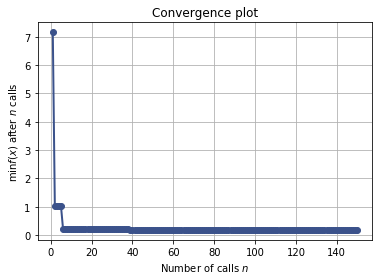

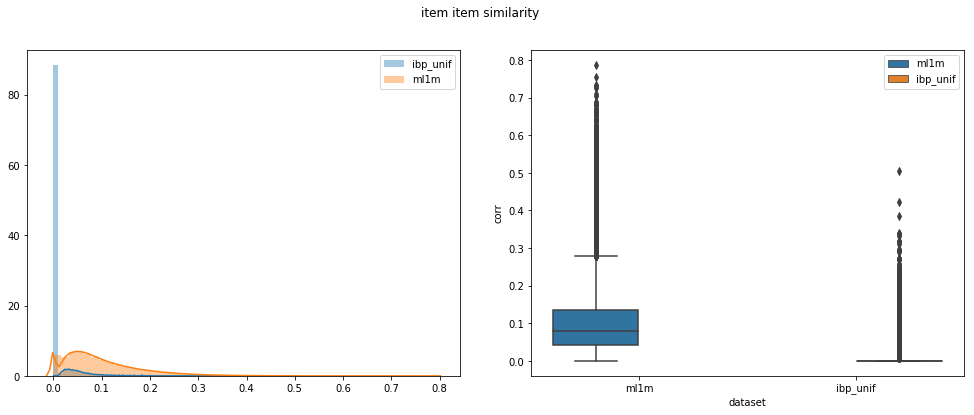

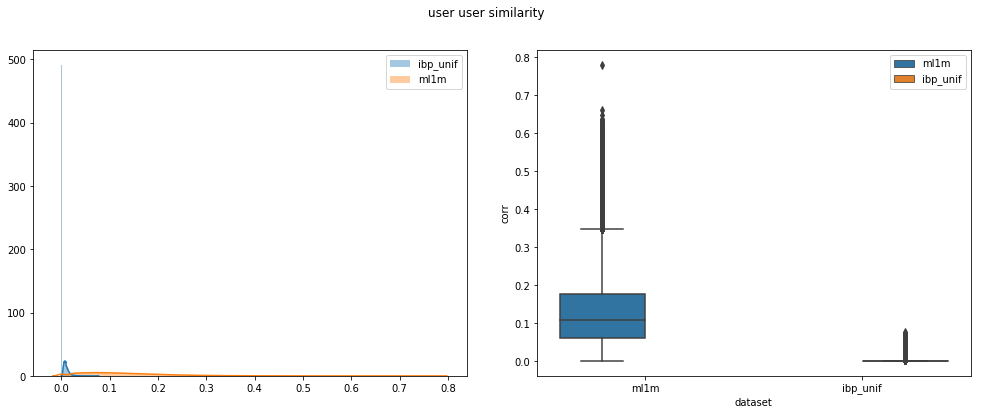

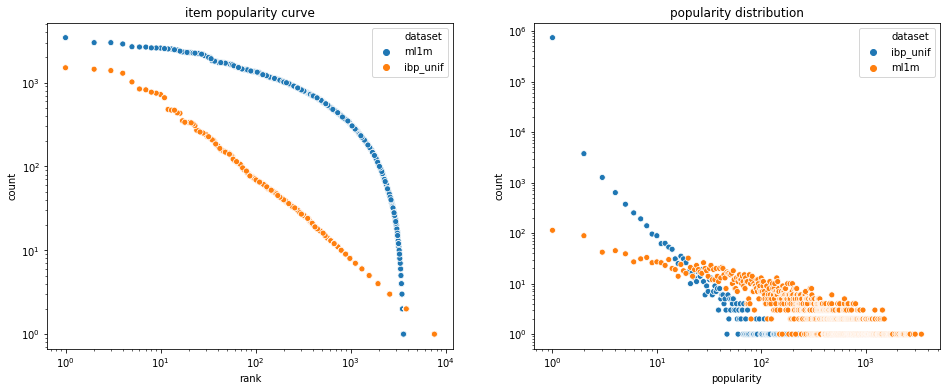

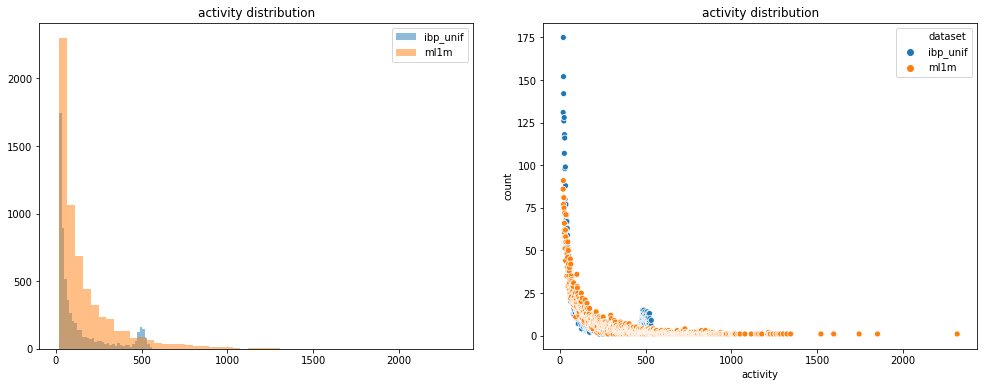

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040  751362   807975  0.000178
item popularity stats
              ml1m       ibp_unif
count  3706.000000  751362.000000
mean    269.889099       1.075347
std     384.047838       4.666234
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       1.000000
max    3428.000000    1500.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   133.770695
std     192.747029   152.709386
min      20.000000    20.000000
25%      44.000000    32.000000
50%      96.000000    59.000000
75%     208.000000   166.000000
max    2314.000000   562.000000


In [35]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-ml_1m-user-act-1-2019-04-05-17-57-47.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_azmi_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', ibp_unif_pareto), args=[339231, 83046, *res_gp.x, 'ibp_unif_azmi_ua.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', simulated_data))

### ibp unif on all

[437.1946475415826, 0.4634912798460673, 0.0, 21.883818537767297, 0.7252611365607432, 1851.2] 1.1929711726762644
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


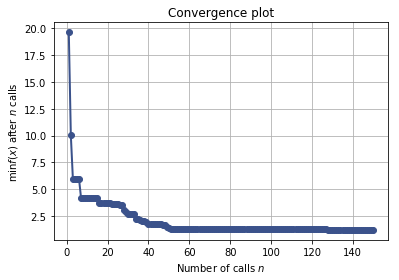

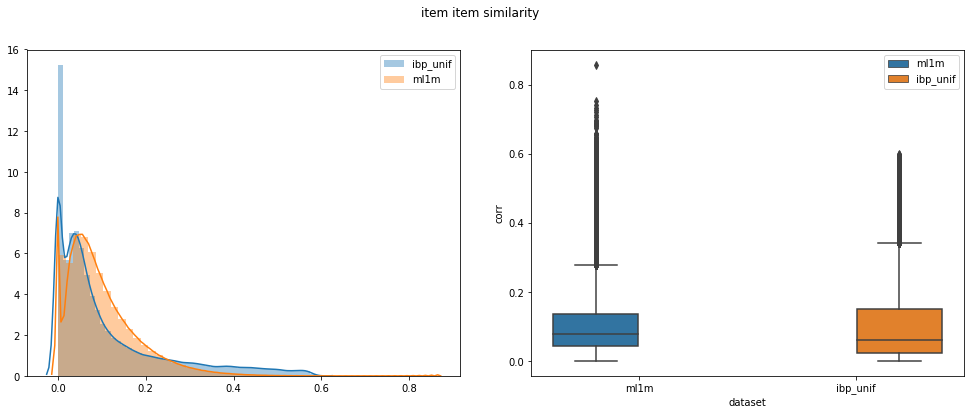

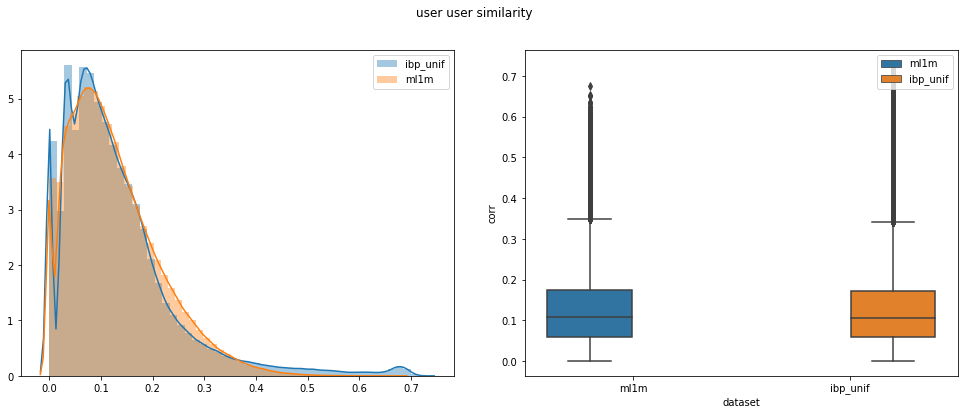

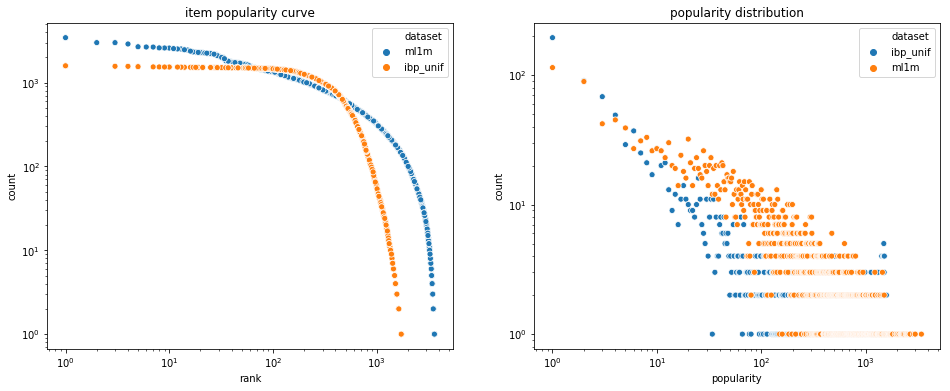

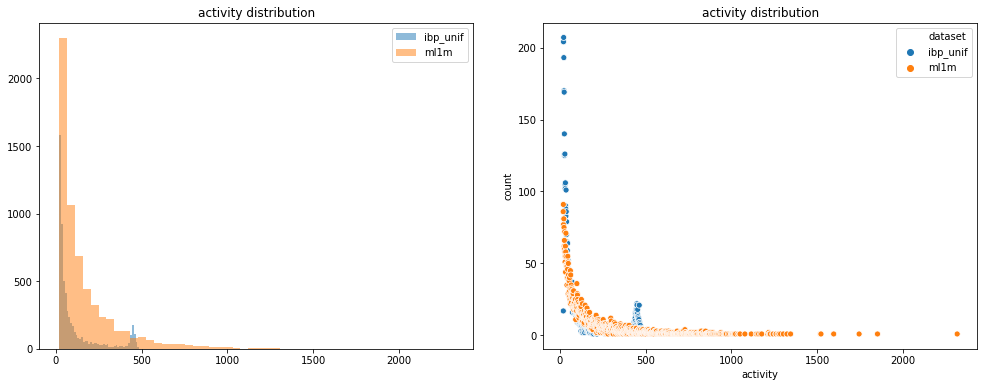

dataset stats
    dataset  nusers  nitems   npairs   density
0      ml1m    6040    3706  1000209  0.044684
1  ibp_unif    6040    1914   682551  0.059041
item popularity stats
              ml1m     ibp_unif
count  3706.000000  1914.000000
mean    269.889099   356.609718
std     384.047838   489.804265
min       1.000000     1.000000
25%      33.000000     7.000000
50%     123.500000    68.000000
75%     350.000000   597.750000
max    3428.000000  1584.000000
user profile stats
              ml1m     ibp_unif
count  6040.000000  6040.000000
mean    165.597517   113.005132
std     192.747029   129.105516
min      20.000000    21.000000
25%      44.000000    31.000000
50%      96.000000    53.000000
75%     208.000000   128.000000
max    2314.000000   486.000000


In [36]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_instruments-all-1-2019-04-08-06-02-01.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_azmi_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', ibp_unif_pareto), args=[339231, 83046, *res_gp.x, 'ibp_unif_azmi_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_unif', simulated_data))

### ibp pop on item item

[1788.4581762317487, 0.9322993977136008, 0.0, 21.531642997711177, 0.4647731544595933, 2110.7818253358723] 0.057097410127544275
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


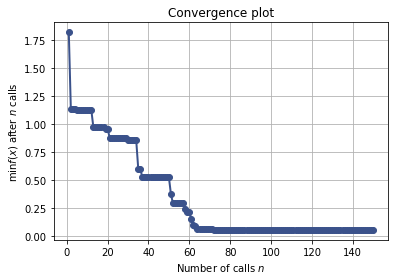

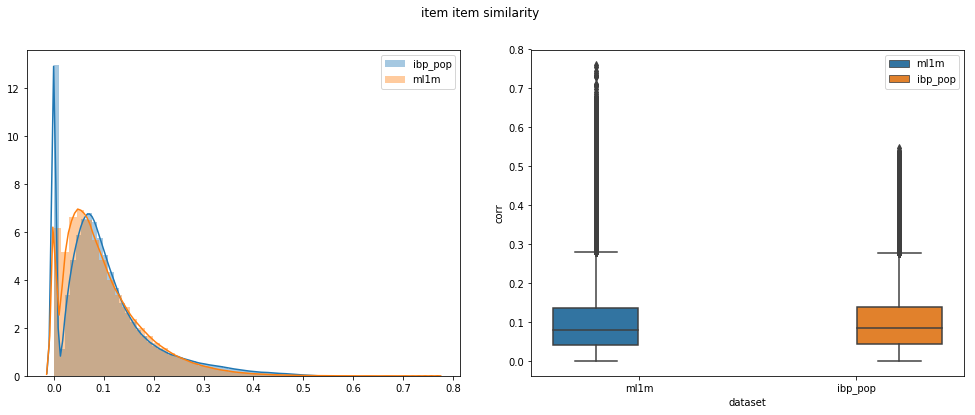

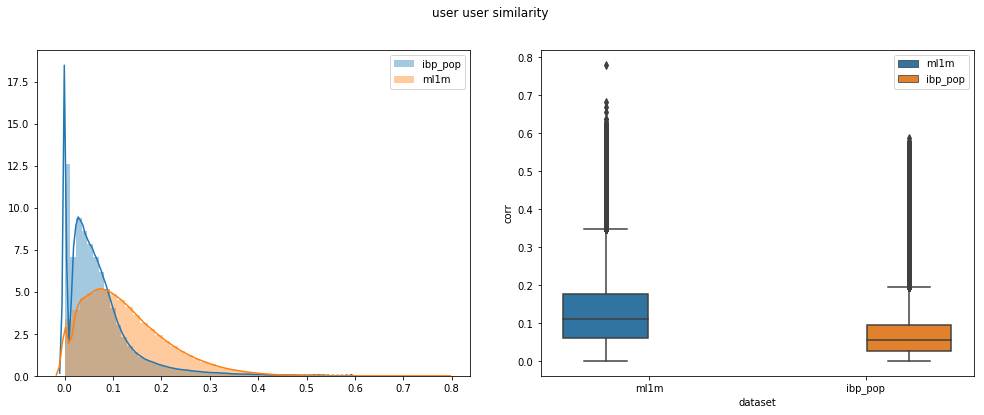

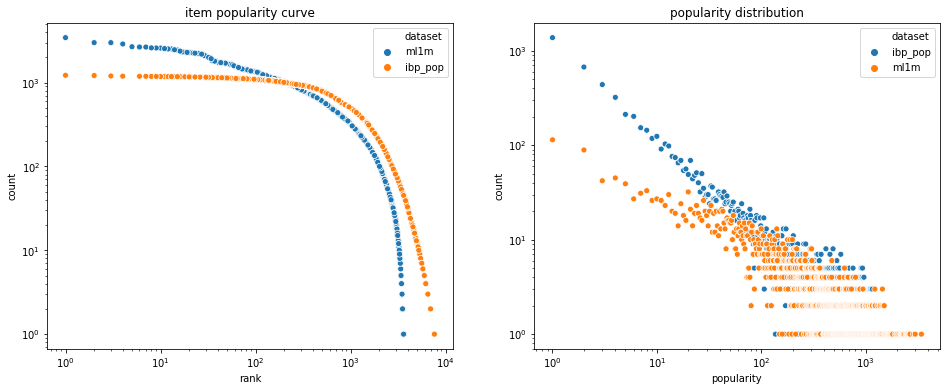

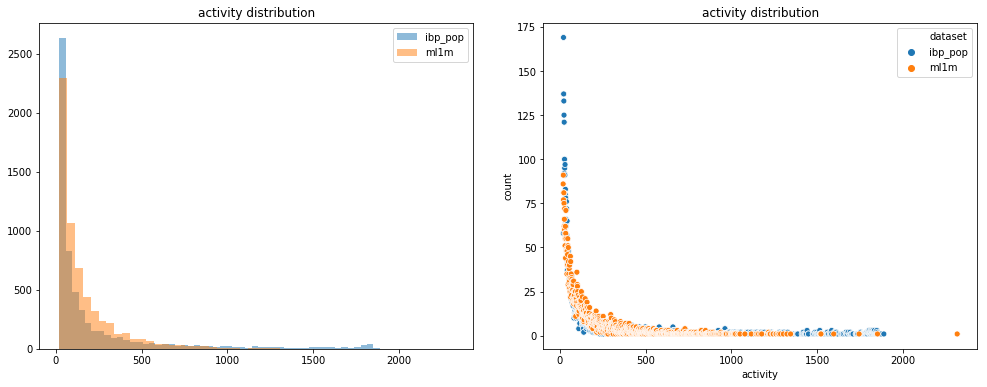

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    8952  1346698  0.024907
item popularity stats
              ml1m      ibp_pop
count  3706.000000  8952.000000
mean    269.889099   150.435433
std     384.047838   262.150457
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    20.000000
75%     350.000000   162.000000
max    3428.000000  1221.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   222.963245
std     192.747029   360.507149
min      20.000000    21.000000
25%      44.000000    35.000000
50%      96.000000    71.000000
75%     208.000000   219.000000
max    2314.000000  1887.000000


In [37]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-icorr-1-2019-04-05-18-33-14.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_azmi_icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', ibp_pop_pareto), args=[339231, 83046, *res_gp.x, 'ibp_pop_azmi_icorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', simulated_data))

### ibp pop on user user

[1795.1592736940415, 0.3715831210952207, 0.6668315406643194, 22.0, 0.19718555841015328, 2357.8672487846184] 0.02947663747191073
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


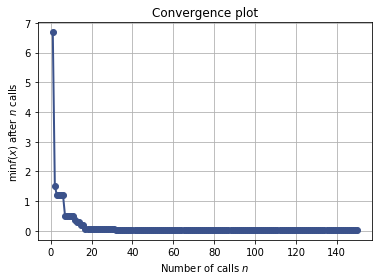

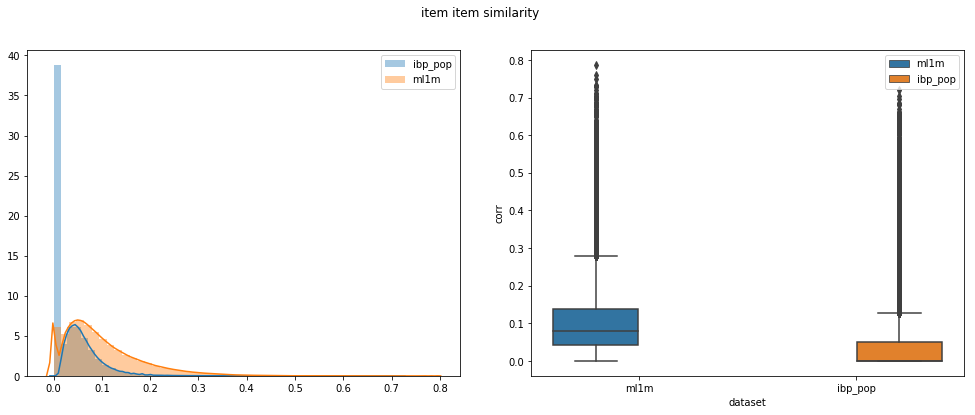

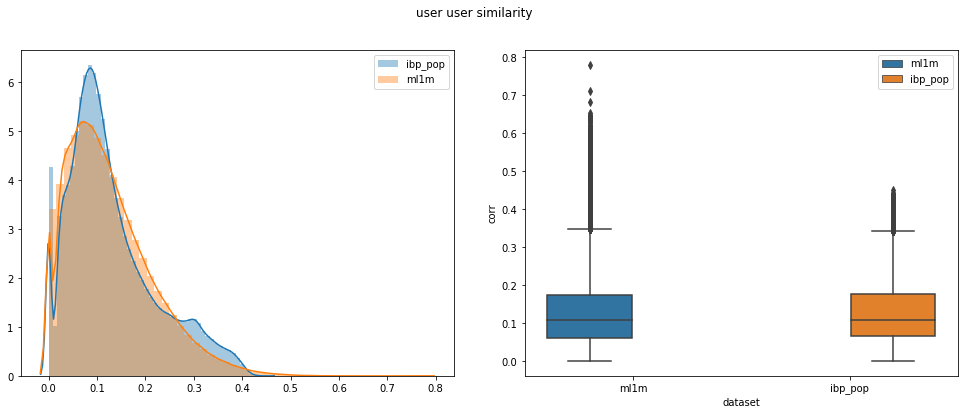

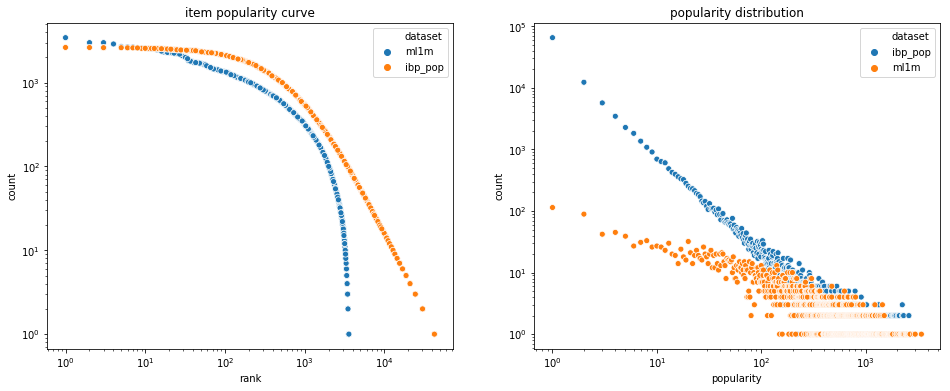

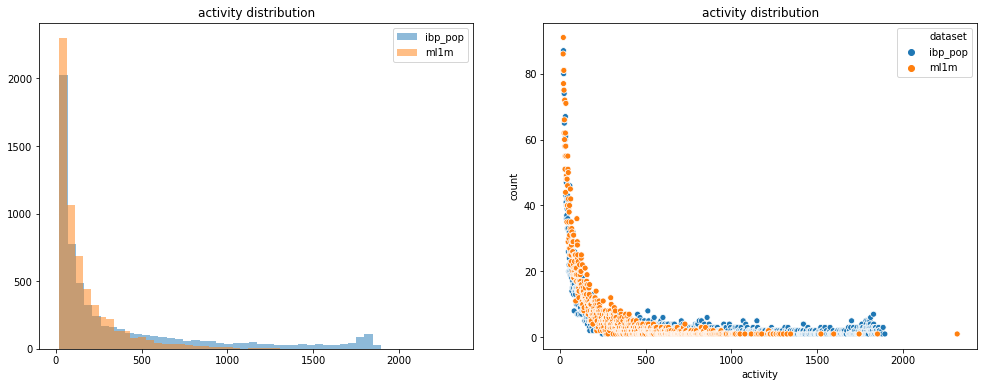

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040  107891  2248581  0.003451
item popularity stats
              ml1m        ibp_pop
count  3706.000000  107891.000000
mean    269.889099      20.841229
std     384.047838     132.167885
min       1.000000       1.000000
25%      33.000000       1.000000
50%     123.500000       1.000000
75%     350.000000       3.000000
max    3428.000000    2621.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   372.281623
std     192.747029   486.485862
min      20.000000    22.000000
25%      44.000000    50.000000
50%      96.000000   137.000000
75%     208.000000   493.000000
max    2314.000000  1893.000000


In [38]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_instruments-ucorr-1-2019-04-08-07-21-09.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_azmi_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', ibp_pop_pareto), args=[339231, 83046, *res_gp.x, 'ibp_pop_azmi_ucorr.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', simulated_data))

### ibp pop on item pop

[20.000000000000004, 4.342722945458372, 0.0, 22.0, 0.1, 2545.4] 0.19725351890396395
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


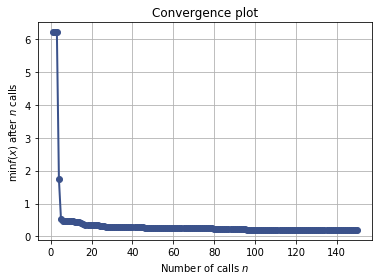

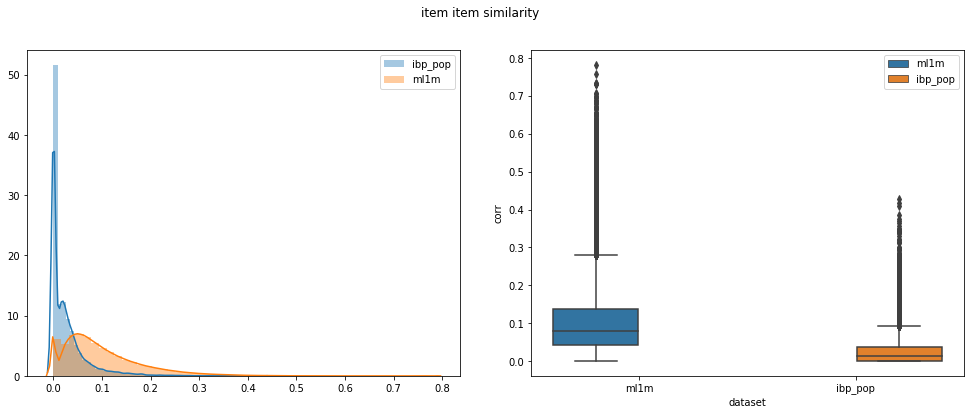

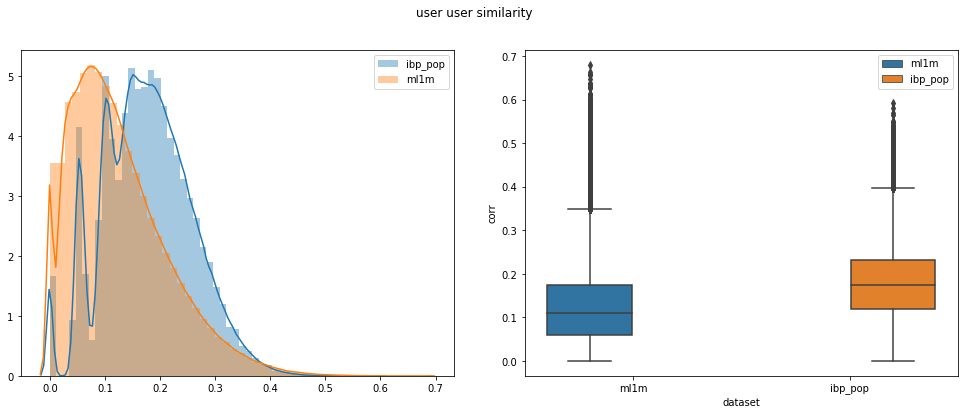

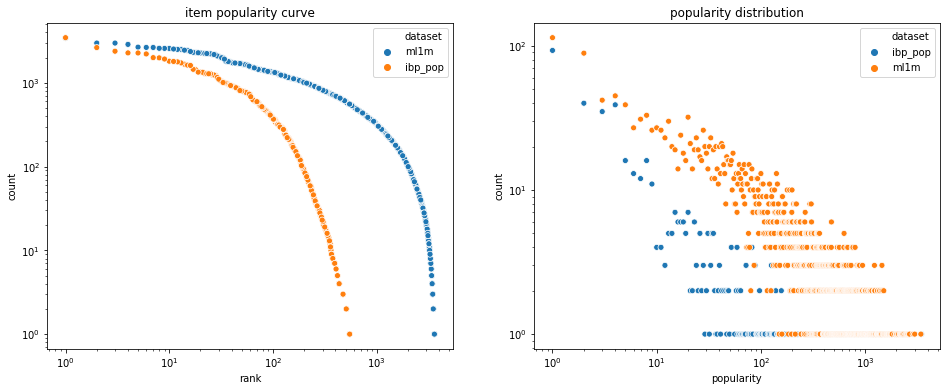

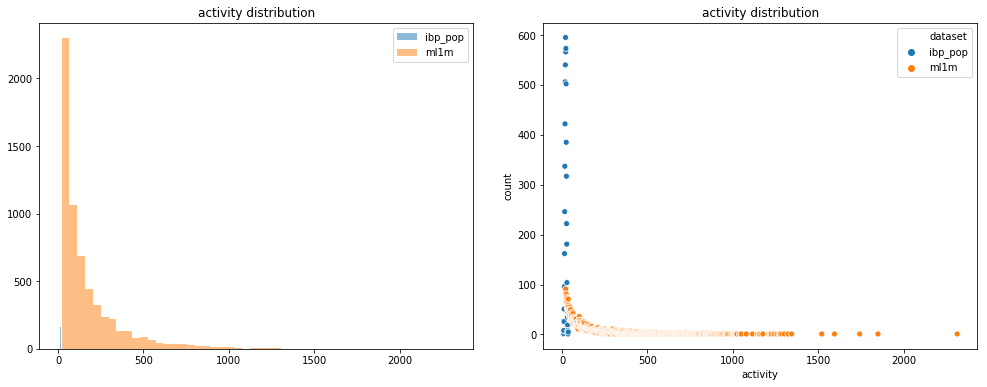

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040     640   124670  0.032251
item popularity stats
              ml1m      ibp_pop
count  3706.000000   640.000000
mean    269.889099   194.796875
std     384.047838   415.382249
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    18.000000
75%     350.000000   164.250000
max    3428.000000  3468.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517    20.640728
std     192.747029     4.066437
min      20.000000     6.000000
25%      44.000000    18.000000
50%      96.000000    21.000000
75%     208.000000    23.000000
max    2314.000000    36.000000


In [39]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-item-pop-1-2019-04-05-20-35-30.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_azmi_ip.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', ibp_pop_pareto), args=[339231, 83046, *res_gp.x, 'ibp_pop_azmi_ip.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', simulated_data))

### ibp pop on user act

[4999.999999999999, 0.01, 0.0, 20.49174680904779, 0.3662436617256628, 2082.600000000001] 0.1222326454719343
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


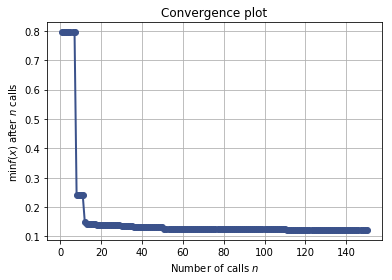

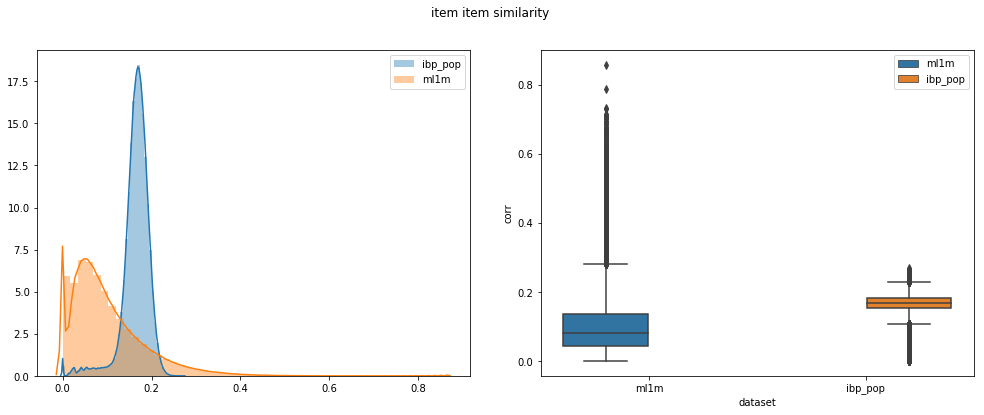

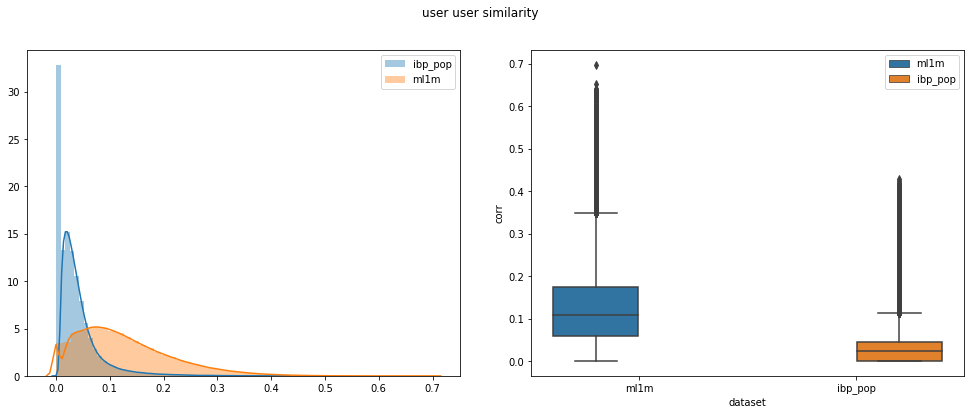

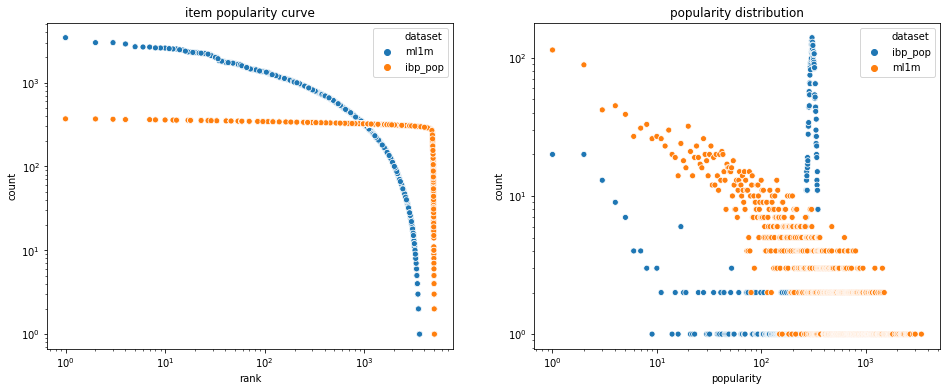

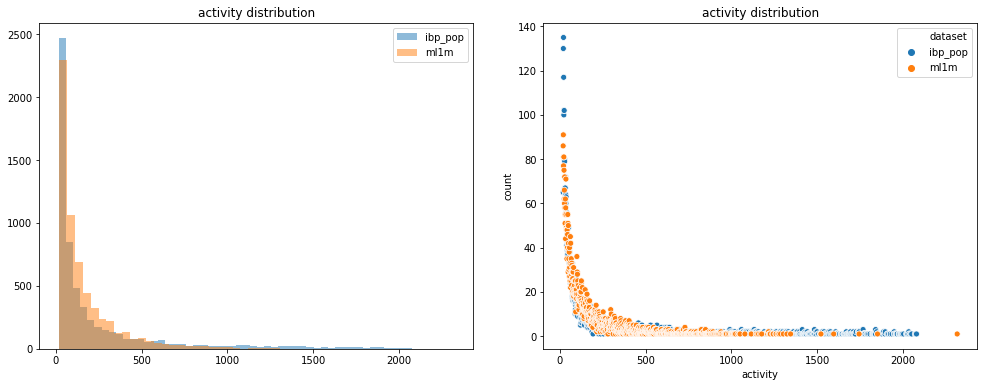

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    5084  1513749  0.049296
item popularity stats
              ml1m      ibp_pop
count  3706.000000  5084.000000
mean    269.889099   297.747640
std     384.047838    55.147625
min       1.000000     1.000000
25%      33.000000   296.000000
50%     123.500000   308.000000
75%     350.000000   319.000000
max    3428.000000   369.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   250.620695
std     192.747029   383.057084
min      20.000000    20.000000
25%      44.000000    37.750000
50%      96.000000    85.000000
75%     208.000000   267.250000
max    2314.000000  2077.000000


In [40]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-ml_1m-user-act-1-2019-04-05-18-33-18.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_azmi_ua.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', ibp_pop_pareto), args=[339231, 83046, *res_gp.x, 'ibp_pop_azmi_ua.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', simulated_data))

### ibp pop on all

[389.32275354686044, 1.0466487147265098, 0.0, 22.0, 0.6304834173274515, 2082.600000000001] 1.827147156895655
file not found, simulating data on the fly


/home/MucunTian/GitProjects/piret-recsys-eval-errors/simulation_utils/datasets.py:55: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  names=['user', 'item', 'rating', 'timestamp'])


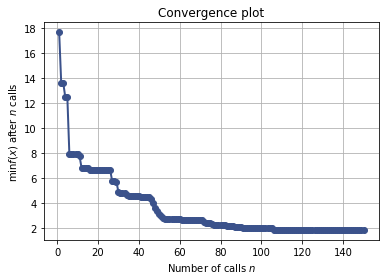

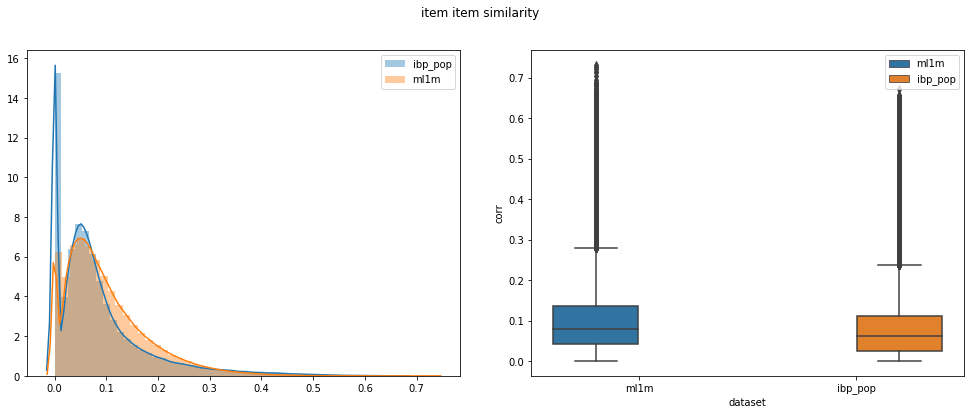

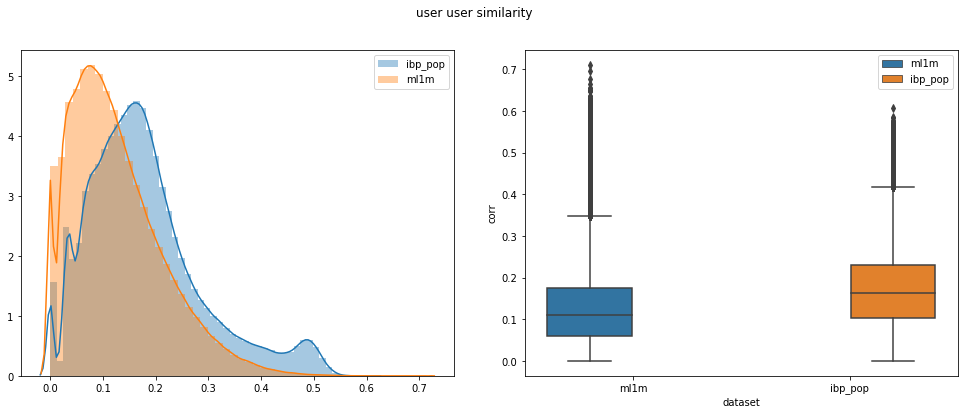

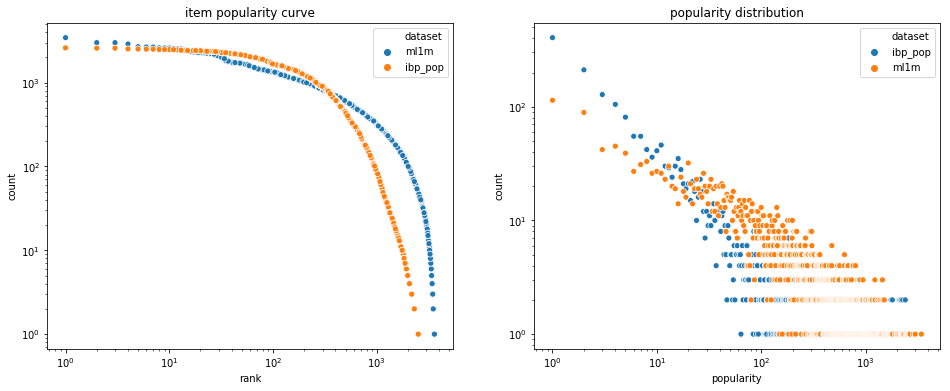

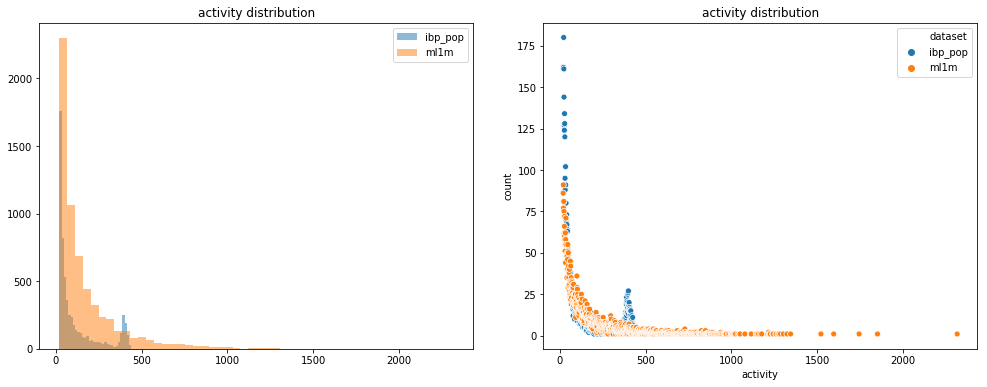

dataset stats
   dataset  nusers  nitems   npairs   density
0     ml1m    6040    3706  1000209  0.044684
1  ibp_pop    6040    2914   725493  0.041220
item popularity stats
              ml1m      ibp_pop
count  3706.000000  2914.000000
mean    269.889099   248.968085
std     384.047838   494.342105
min       1.000000     1.000000
25%      33.000000     3.000000
50%     123.500000    21.500000
75%     350.000000   203.750000
max    3428.000000  2589.000000
user profile stats
              ml1m      ibp_pop
count  6040.000000  6040.000000
mean    165.597517   120.114735
std     192.747029   124.767014
min      20.000000    22.000000
25%      44.000000    33.000000
50%      96.000000    59.000000
75%     208.000000   155.000000
max    2314.000000   440.000000


In [41]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_instruments-all-1-2019-04-08-17-06-46.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_azmi_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', ibp_pop_pareto), args=[339231, 83046, *res_gp.x, 'ibp_pop_azmi_all.pkl'])
else:
    print('simulated data is used')
    plot_stats(('azmi', az_music_instruments), ('ibp_pop', simulated_data))

## Amazon music

### lda unif on user user

[53, 23.105379111116434, 0.09561713698037405, 0.04851186469127432, 1.0805880075120726, 0.44885377927998416, 1204.4781013039783] 0.0028980398703731015
simulated data is used


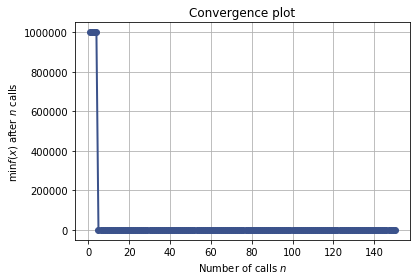

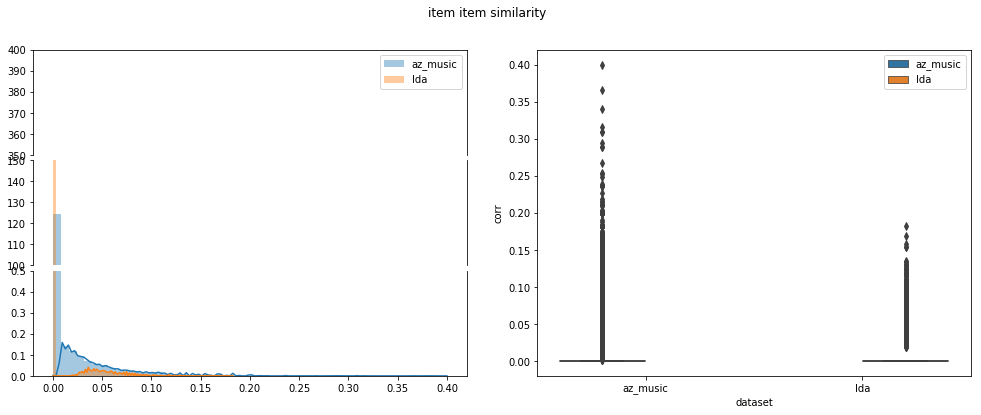

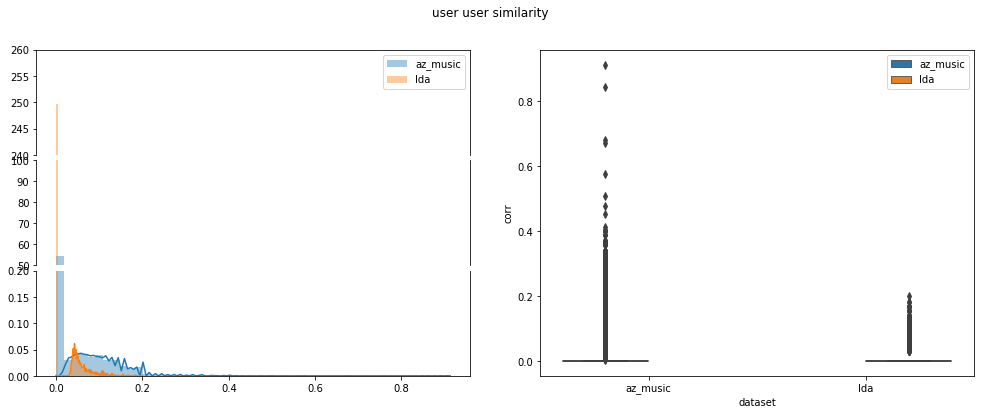

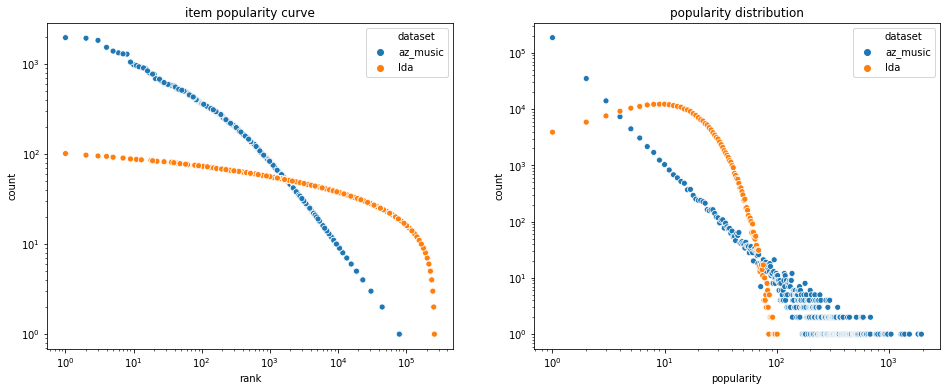

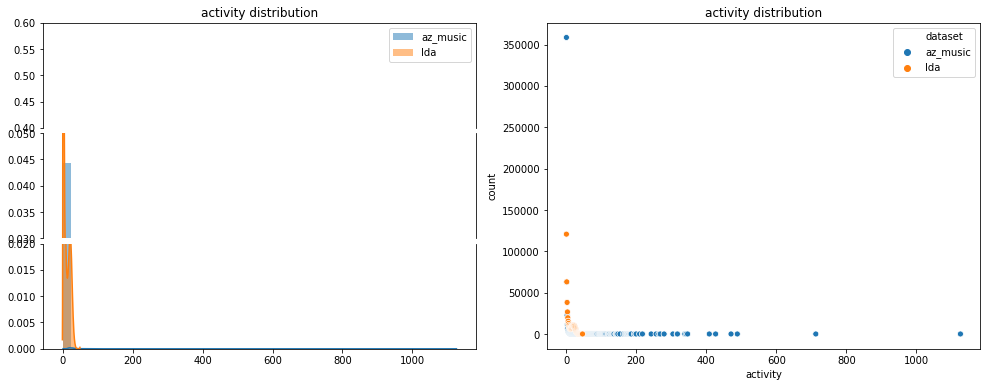

dataset stats
    dataset  nusers  nitems   npairs   density
0  az_music  478235  266414   836006  0.000007
1       lda  478235  264633  4157196  0.000033
item popularity stats
            az_music            lda
count  266414.000000  264633.000000
mean        3.137996      15.709288
std        17.532391      10.438294
min         1.000000       1.000000
25%         1.000000       8.000000
50%         1.000000      14.000000
75%         2.000000      21.000000
max      1953.000000     101.000000
user profile stats
            az_music            lda
count  478235.000000  478235.000000
mean        1.748107       8.692789
std         4.227086       8.976456
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       4.000000
75%         2.000000      16.000000
max      1126.000000      47.000000


In [43]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music-ucorr-1-2019-04-05-18-00-32.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azm_ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azm', az_music), ('lda', lda_unif_pareto), args=[478235, 266414, *res_gp.x, 'lda_unif_azm_ucorr.pkl'],
               ylim_left=((350, 400), (100, 150), (0, 0.5)), ylim_left2=((240, 260), (50, 100), (0, 0.2)), ylim_left4=((0.4, 0.6), (0.03, 0.05), (0, 0.02)))
else:
    print('simulated data is used')
    plot_stats(('az_music', az_music), ('lda', simulated_data),
               ylim_left=((350, 400), (100, 150), (0, 0.5)), ylim_left2=((240, 260), (50, 100), (0, 0.2)), ylim_left4=((0.4, 0.6), (0.03, 0.05), (0, 0.02)))

### lda unif on all

[55, 62.57844803378988, 0.08055662842975703, 0.13166803162648694, 1.0574749636966985, 1.4414961975146197, 919.4122148668087] 1.5238229312896765
simulated data is used


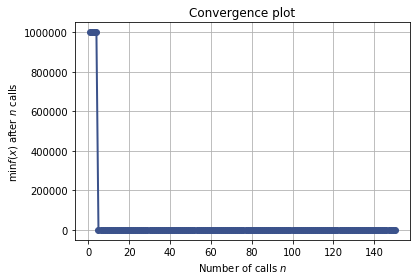

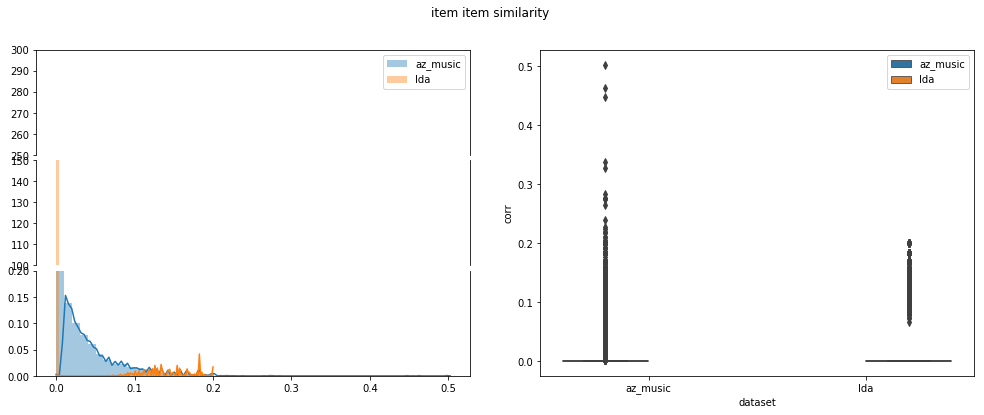

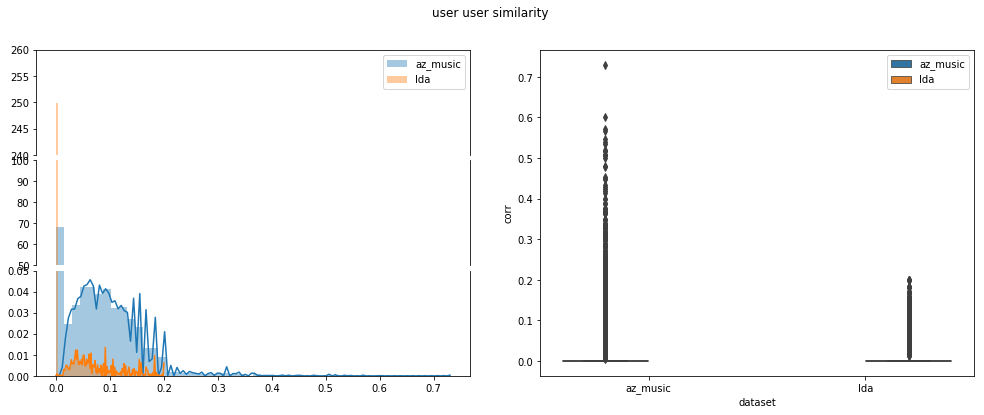

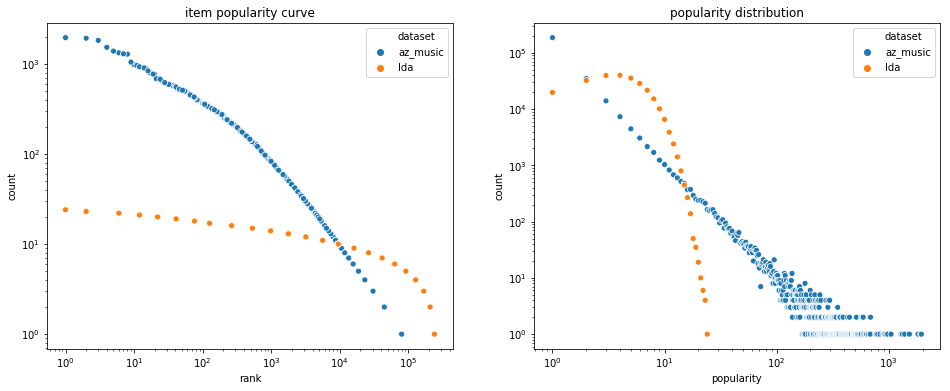

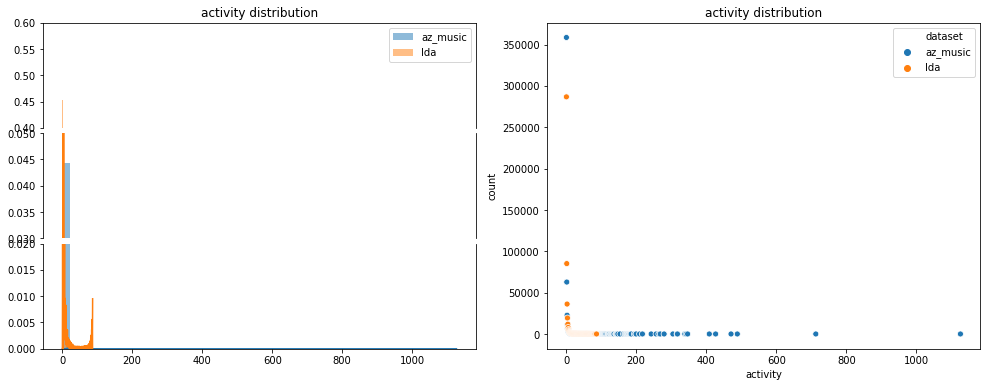

dataset stats
    dataset  nusers  nitems   npairs   density
0  az_music  478235  266414   836006  0.000007
1       lda  478235  259413  1261801  0.000010
item popularity stats
            az_music            lda
count  266414.000000  259413.000000
mean        3.137996       4.864062
std        17.532391       2.719221
min         1.000000       1.000000
25%         1.000000       3.000000
50%         1.000000       4.000000
75%         2.000000       6.000000
max      1953.000000      24.000000
user profile stats
            az_music            lda
count  478235.000000  478235.000000
mean        1.748107       2.638454
std         4.227086       5.186007
min         1.000000       1.000000
25%         1.000000       1.000000
50%         1.000000       1.000000
75%         2.000000       2.000000
max      1126.000000      87.000000


In [47]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music-all-1-2019-04-05-18-00-57.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_azm_all.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azm', az_music), ('lda', lda_unif_pareto), args=[478235, 266414, *res_gp.x, 'lda_unif_azm_all.pkl'],
               ylim_left=((250, 300), (100, 150), (0, 0.2)), ylim_left2=((240, 260), (50, 100), (0, 0.05)), ylim_left4=((0.4, 0.6), (0.03, 0.05), (0, 0.02)))
else:
    print('simulated data is used')
    plot_stats(('az_music', az_music), ('lda', simulated_data),
               ylim_left=((250, 300), (100, 150), (0, 0.2)), ylim_left2=((240, 260), (50, 100), (0, 0.05)), ylim_left4=((0.4, 0.6), (0.03, 0.05), (0, 0.02)))